In [1]:
# Cell 1: Setup and Installations
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install scikit-learn matplotlib seaborn pandas

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create output directory
import os
output_dir = '/content/drive/MyDrive/ATML_Task3_Results'
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oytc2vok
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oytc2vok
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=97a18d6338f0976aa82ecb09264142ffd780f4c7d6044e3cf4135e060b64c368
  Stored in directory: /tmp/pip-ephem-wheel-cache-qeyh08cr/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Mounted at /content/drive
Results will be saved to: /content/drive/MyDrive/ATML_Task3_Results


In [2]:
# Cell 2: Import Libraries and Helper Functions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import clip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import json
from collections import defaultdict
import copy

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("Setup complete!")

Using device: cuda
Setup complete!


In [3]:
# PACS class names
PACS_CLASSES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
DOMAINS = ["Photo", "Art_painting", "Cartoon", "Sketch"]
# ['art_painting', 'cartoon', 'photo', 'sketch']

In [4]:
from pathlib import Path
import os, shutil
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

# Paths
DRIVE_DIR = Path("/content/drive/MyDrive/DG_PACS")
PACS_DIR  = DRIVE_DIR / "PACS"   # <-- write directly to Drive
DRIVE_DIR.mkdir(parents=True, exist_ok=True)

# If you already have a broken symlink named PACS in Drive, remove it:
if PACS_DIR.exists() and PACS_DIR.is_symlink():
    PACS_DIR.unlink()

# Build PACS into Drive
if PACS_DIR.exists() and any(PACS_DIR.iterdir()):
    print("PACS already exists at", PACS_DIR, "- keeping it.")
else:
    ds_all = load_dataset("flwrlabs/pacs")
    for split in ds_all.keys():
        ds = ds_all[split]
        label_feature  = ds.features.get("label", None)
        domain_feature = ds.features.get("domain", None)
        label_names  = (label_feature.names  if hasattr(label_feature, "names")  else None)
        domain_names = (domain_feature.names if hasattr(domain_feature, "names") else None)

        for i, row in enumerate(tqdm(ds, desc=f"Writing {split}")):
            img = row["image"]
            lbl = row.get("label")
            dom = row.get("domain")

            cls_name = label_names[lbl] if isinstance(lbl, int) and label_names else str(lbl)
            dom_name = domain_names[dom] if isinstance(dom, int) and domain_names else str(dom)

            canon = {
                "art_painting":"Art_painting", "art painting":"Art_painting",
                "cartoon":"Cartoon", "photo":"Photo", "sketch":"Sketch"
            }
            dom_name = canon.get(str(dom_name).lower().replace("-", " ").replace("_", " "), dom_name)

            out_dir = PACS_DIR / dom_name / cls_name
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / f"{split}_{i:06d}.jpg"
            (img if isinstance(img, Image.Image) else Image.fromarray(img)).save(out_path, format="JPEG")

    print("✅ PACS written to:", PACS_DIR)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Writing train: 100%|██████████| 9991/9991 [01:37<00:00, 102.35it/s]

✅ PACS written to: /content/drive/MyDrive/DG_PACS/PACS


In [ ]:
# # Cell 1: Data Loading and CLIP Model Setup
# # Download PACS dataset first (you'll need to download it separately)
# # Expected structure: /content/PACS/{domain}/{class}/images

# import urllib.request
# import zipfile

# # Helper function to load PACS data
# def get_pacs_loaders(root_dir='/content/drive/MyDrive/DG_PACS/PACS', batch_size=32, domain=None):
#     """Load PACS dataset for specific domain or all domains"""

#     # CLIP preprocessing
#     _, preprocess = clip.load("ViT-B/32", device=device)

#     if domain:
#         dataset = ImageFolder(f"{root_dir}/{domain}", transform=preprocess)
#         loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
#         return loader
#     else:
#         loaders = {}
#         for dom in DOMAINS:
#             dataset = ImageFolder(f"{root_dir}/{dom}", transform=preprocess)
#             loaders[dom] = DataLoader(dataset, batch_size=batch_size, shuffle=True if dom != 'sketch' else False, num_workers=2)
#         return loaders

# # Load CLIP model
# model, preprocess = clip.load("ViT-B/32", device=device)
# model.eval()

# print("CLIP model loaded successfully!")
# print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Load data (adjust path as needed)
# try:
#     all_loaders = get_pacs_loaders(root_dir='/content/drive/MyDrive/DG_PACS/PACS', batch_size=64)
#     print("Data loaded successfully!")
#     for domain, loader in all_loaders.items():
#         print(f"{domain}: {len(loader.dataset)} images")
# except:
#     print("Please download PACS dataset and place it in /content/drive/MyDrive/DG_PACS/")
#     print("Expected structure: /content/drive/MyDrive/DG_PACS/PACS{domain}/{class}/images")

CLIP model loaded successfully!
Model parameters: 151,277,313
Data loaded successfully!
Photo: 1670 images
Art_painting: 2048 images
Cartoon: 2344 images
Sketch: 3929 images


In [5]:
import clip
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch

# === GLOBALS ===
PACS_CLASSES = ["dog","elephant","giraffe","guitar","horse","house","person"]
CLASS2IDX = {c:i for i,c in enumerate(PACS_CLASSES)}

# === Dataset wrapper for unified class mapping ===
class RemapDataset(Dataset):
    def __init__(self, imgfolder_ds):
        self.ds = imgfolder_ds
        # sanity: check all class names are known
        unknown = [c for c in self.ds.classes if c not in CLASS2IDX]
        if unknown:
            raise ValueError(f"Unknown classes in {self.ds.root}: {unknown}")
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        x, old_y = self.ds[idx]
        cls_name = self.ds.classes[old_y]
        y = CLASS2IDX[cls_name]
        return x, y

# === Loader builder (same interface as before) ===
def get_pacs_loaders(root_dir='/content/drive/MyDrive/DG_PACS/PACS', batch_size=32, domain=None):
    """Load PACS dataset for specific domain or all domains (with unified labels)"""
    _, preprocess = clip.load("ViT-B/32", device=device)

    def make_loader(domain_name, shuffle_flag):
        ds = ImageFolder(f"{root_dir}/{domain_name}", transform=preprocess)
        ds = RemapDataset(ds)  # ensure consistent label mapping
        return DataLoader(ds, batch_size=batch_size, shuffle=shuffle_flag, num_workers=2)

    if domain:
        shuffle_flag = False if domain.lower() == 'sketch' else True
        return make_loader(domain, shuffle_flag)
    else:
        loaders = {}
        for dom in DOMAINS:
            shuffle_flag = False if dom.lower() == 'sketch' else True
            loaders[dom] = make_loader(dom, shuffle_flag)
        return loaders

# === Example usage (unchanged downstream) ===
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
print("CLIP model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

try:
    all_loaders = get_pacs_loaders(root_dir='/content/drive/MyDrive/DG_PACS/PACS', batch_size=64)
    print("Data loaded successfully!")
    for domain, loader in all_loaders.items():
        print(f"{domain}: {len(loader.dataset)} images | classes: {loader.dataset.ds.classes}")
except Exception as e:
    print("Please download PACS dataset and place it in /content/drive/MyDrive/DG_PACS/")
    print("Expected structure: /content/drive/MyDrive/DG_PACS/PACS/{domain}/{class}/images")
    print("Error:", e)


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 79.0MiB/s]


CLIP model loaded successfully!
Model parameters: 151,277,313
Data loaded successfully!
Photo: 1670 images | classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Art_painting: 2048 images | classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Cartoon: 2344 images | classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Sketch: 3929 images | classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']



# Subtask 3.1: CLIP Zero-Shot vs Fine-Tuned

ZERO-SHOT EVALUATION

--- Generic Prompts ---

Evaluating Photo...


Zero-shot classification: 100%|██████████| 27/27 [00:10<00:00,  2.62it/s]


Photo (generic): 0.9982

Evaluating Art_painting...


Zero-shot classification: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Art_painting (generic): 0.9629

Evaluating Cartoon...


Zero-shot classification: 100%|██████████| 37/37 [00:16<00:00,  2.28it/s]


Cartoon (generic): 0.9804

Evaluating Sketch...


Zero-shot classification: 100%|██████████| 62/62 [00:22<00:00,  2.80it/s]


Sketch (generic): 0.8458

--- Domain-Specific Prompts ---

Evaluating Art_painting...


Zero-shot classification: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Art_painting (specific): 0.9565

Evaluating Cartoon...


Zero-shot classification: 100%|██████████| 37/37 [00:13<00:00,  2.77it/s]


Cartoon (specific): 0.9821

Evaluating Photo...


Zero-shot classification: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Photo (specific): 0.9982

Evaluating Sketch...


Zero-shot classification: 100%|██████████| 62/62 [00:25<00:00,  2.41it/s]


Sketch (specific): 0.8509

      Domain  Generic Prompts  Domain-Specific Prompts  Improvement
       Photo         0.998204                 0.998204     0.000000
Art_painting         0.962891                 0.956543    -0.006348
     Cartoon         0.980375                 0.982082     0.001706
      Sketch         0.845762                 0.850853     0.005090


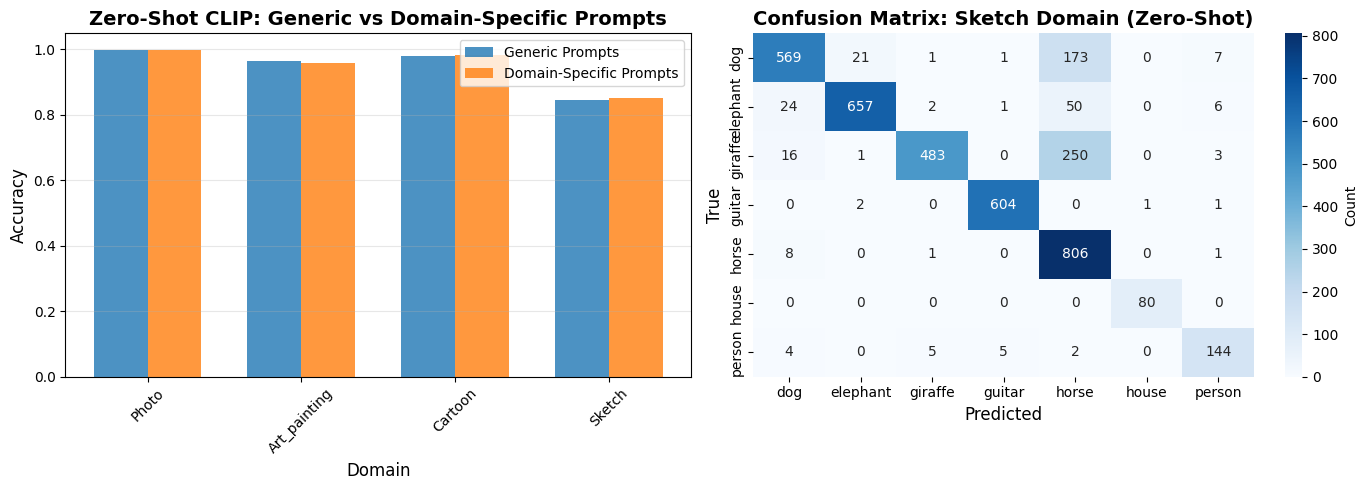


Results saved to /content/drive/MyDrive/ATML_Task3_Results


In [ ]:
# Cell 2: Zero-Shot Evaluation with Multiple Prompt Templates
def zero_shot_classify(model, loader, class_names, prompt_templates, device):
    """Perform zero-shot classification with CLIP"""
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    all_features = []

    with torch.no_grad():
        # Create text features for all prompt templates
        text_features_list = []
        for template in prompt_templates:
            texts = [template.format(c) for c in class_names]
            text_inputs = clip.tokenize(texts).to(device)
            text_features = model.encode_text(text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            text_features_list.append(text_features)

        # Average text features across templates (ensemble)
        text_features = torch.stack(text_features_list).mean(dim=0)

        # Classify images
        for images, labels in tqdm(loader, desc="Zero-shot classification"):
            images = images.to(device)

            # Get image features
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # Calculate similarity
            similarity = (100.0 * image_features @ text_features.T)
            probs = similarity.softmax(dim=-1)
            preds = similarity.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            all_features.append(image_features.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return {
        'accuracy': accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'features': np.vstack(all_features)
    }

# Define prompt templates (domain-specific and generic)
prompt_templates_generic = [
    "a photo of a {}.",
    "a picture of a {}.",
    "an image of a {}.",
]

prompt_templates_domain_specific = {
    'Art_painting': ["a painting of a {}.", "an artistic depiction of a {}.", "art showing a {}."],
    'Cartoon': ["a cartoon of a {}.", "an animated drawing of a {}.", "a cartoon illustration of a {}."],
    'Photo': ["a photo of a {}.", "a photograph of a {}.", "a picture of a {}."],
    'Sketch': ["a sketch of a {}.", "a drawing of a {}.", "a pencil sketch of a {}."],
}

# Evaluate zero-shot on all domains
print("="*50)
print("ZERO-SHOT EVALUATION")
print("="*50)

zero_shot_results = {}

# Test with generic prompts
print("\n--- Generic Prompts ---")
for domain, loader in all_loaders.items():
    print(f"\nEvaluating {domain}...")
    results = zero_shot_classify(model, loader, PACS_CLASSES, prompt_templates_generic, device)
    zero_shot_results[f"{domain}_generic"] = results
    print(f"{domain} (generic): {results['accuracy']:.4f}")

# Test with domain-specific prompts
print("\n--- Domain-Specific Prompts ---")
# Iterate through the keys of prompt_templates_domain_specific instead of DOMAINS
for domain, templates in prompt_templates_domain_specific.items():
    if domain in all_loaders: # Check if loader exists for this domain
        loader = all_loaders[domain]
        print(f"\nEvaluating {domain}...")
        results = zero_shot_classify(model, loader, PACS_CLASSES,
                                     templates, device)
        zero_shot_results[f"{domain}_specific"] = results
        print(f"{domain} (specific): {results['accuracy']:.4f}")
    else:
        print(f"\nLoader not found for domain: {domain}. Skipping domain-specific evaluation.")


# Create comparison table
results_df = pd.DataFrame({
    'Domain': DOMAINS,
    'Generic Prompts': [zero_shot_results[f"{d}_generic"]['accuracy'] for d in DOMAINS],
    'Domain-Specific Prompts': [zero_shot_results[f"{d}_specific"]['accuracy'] for d in DOMAINS],
    'Improvement': [zero_shot_results[f"{d}_specific"]['accuracy'] -
                    zero_shot_results[f"{d}_generic"]['accuracy'] for d in DOMAINS]
})

print("\n" + "="*50)
print(results_df.to_string(index=False))
print("="*50)

# Save results
results_df.to_csv(f"{output_dir}/subtask3.1_zero_shot_comparison.csv", index=False)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot comparison
x = np.arange(len(DOMAINS))
width = 0.35
ax1.bar(x - width/2, results_df['Generic Prompts'], width, label='Generic Prompts', alpha=0.8)
ax1.bar(x + width/2, results_df['Domain-Specific Prompts'], width, label='Domain-Specific Prompts', alpha=0.8)
ax1.set_xlabel('Domain', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Zero-Shot CLIP: Generic vs Domain-Specific Prompts', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(DOMAINS, rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Confusion matrix for Sketch domain (target)
cm = confusion_matrix(zero_shot_results['Sketch_specific']['labels'],
                      zero_shot_results['Sketch_specific']['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=PACS_CLASSES,
            yticklabels=PACS_CLASSES, ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title('Confusion Matrix: Sketch Domain (Zero-Shot)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.savefig(f"{output_dir}/subtask3.1_zero_shot_evaluation.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResults saved to {output_dir}")

Fine-Tuning CLIP

In [ ]:
# Cell 1: Linear Probe Training (Fine-tuning classifier on top of frozen CLIP)
# ===== Linear Probe on CLIP (frozen image encoder) =====
import torch, copy
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import numpy as np

# 0) Config
PACS_CLASSES = ["dog","elephant","giraffe","guitar","horse","house","person"]
CLASS2IDX = {c:i for i,c in enumerate(PACS_CLASSES)}
NUM_CLASSES = len(PACS_CLASSES)

# 1) Ensure CLIP preprocess is used for ALL splits
import clip
clip_model_ft, clip_preprocess = clip.load("ViT-B/32", device=device)

# If you build ImageFolder datasets elsewhere, make sure to pass `transform=clip_preprocess`.
# Example:
# photo_ds   = ImageFolder(root=..., transform=clip_preprocess)
# art_ds     = ImageFolder(root=..., transform=clip_preprocess)
# cartoon_ds = ImageFolder(root=..., transform=clip_preprocess)
# sketch_ds  = ImageFolder(root=..., transform=clip_preprocess)

# 2) Remap labels using a single, global class order
class RemapDataset(Dataset):
    def __init__(self, imgfolder_ds):
        self.ds = imgfolder_ds
        self.classes = self.ds.classes  # class names in that folder
        # quick check: all names must exist in PACS_CLASSES
        missing = [c for c in self.classes if c not in CLASS2IDX]
        if missing:
            raise ValueError(f"Classes not in global mapping: {missing}")
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x, old_y = self.ds[i]                   # old_y is per-domain index
        cls_name = self.ds.classes[old_y]       # recover class name
        y = CLASS2IDX[cls_name]                 # unified id
        return x, y

# 3) Dataloaders (wrap your existing datasets)
def make_loader(ds, batch_size=64, shuffle=False, num_workers=4):
    return DataLoader(RemapDataset(ds), batch_size=batch_size,
                      shuffle=shuffle, num_workers=num_workers,
                      pin_memory=True, drop_last=False)

# Example (replace with your actual datasets):
# loaders = {
#   "Photo":    make_loader(photo_ds,   batch_size=64, shuffle=True),
#   "Art_painting": make_loader(art_ds, batch_size=64, shuffle=True),
#   "Cartoon":  make_loader(cartoon_ds, batch_size=64, shuffle=True),
#   "Sketch":   make_loader(sketch_ds,  batch_size=64, shuffle=False),
# }
# Train on Photo/Art/Cartoon; validate on Sketch
# train_loaders_ft = {k:v for k,v in loaders.items() if k != "Sketch"}
# val_loader_ft    = loaders["Sketch"]

# 4) Linear head in FP32; cast features to float
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes, freeze_backbone=True):
        super().__init__()
        self.clip_model = clip_model
        self.freeze_backbone = freeze_backbone
        if freeze_backbone:
            for p in self.clip_model.parameters():
                p.requires_grad = False

        with torch.no_grad():
            dummy = torch.randn(1,3,224,224, device=device)
            f = self.clip_model.encode_image(dummy)   # likely fp16
            self.feature_dim = f.shape[1]

        self.classifier = nn.Linear(self.feature_dim, num_classes).float()  # FP32 head

    def forward(self, images):
        if self.freeze_backbone:
            with torch.no_grad():
                feats = self.clip_model.encode_image(images)
        else:
            feats = self.clip_model.encode_image(images)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        return self.classifier(feats.float())

# 5) Train / eval
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.05, reduction="mean"):
        super().__init__()
        self.eps = eps; self.reduction = reduction
    def forward(self, logits, target):
        n = logits.size(-1)
        logp = torch.log_softmax(logits, dim=-1)
        loss = -logp.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        loss = (1 - self.eps) * loss - self.eps * logp.mean(dim=-1)
        return loss.mean() if self.reduction == "mean" else loss.sum()

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
    return correct / max(1,total)

def train_linear_probe(model, train_loaders, val_loader, num_epochs=30, lr=0.02):
    # optimize only the head if backbone is frozen
    params = model.classifier.parameters() if model.freeze_backbone else model.parameters()
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = LabelSmoothingCE(eps=0.05)

    train_history = {'loss': [], 'acc': []}
    val_history   = {'loss': [], 'acc': []}
    best_val_acc, best_state = 0.0, None

    for epoch in range(num_epochs):
        model.train()
        if model.freeze_backbone: model.clip_model.eval()

        running_loss = 0.0
        running_correct = 0
        running_total = 0
        batchs = 0

        # iterate over all source-domain loaders
        for domain, loader in train_loaders.items():
            if domain.lower() == "sketch":   # safety
                continue
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                logits = model(images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                running_loss   += loss.item()
                running_total  += labels.size(0)
                running_correct+= (logits.argmax(1)==labels).sum().item()
                batchs += 1

        train_acc = running_correct / max(1, running_total)
        avg_train_loss = running_loss / max(1, batchs)
        train_history['loss'].append(avg_train_loss)
        train_history['acc'].append(train_acc)

        # ---- validation (target: Sketch) ----
        model.eval()
        val_loss = 0.0; val_correct = 0; val_total = 0; vb = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                val_loss += criterion(logits, labels).item()
                val_correct += (logits.argmax(1)==labels).sum().item()
                val_total += labels.size(0)
                vb += 1
        val_acc = val_correct / max(1, val_total)
        avg_val_loss = val_loss / max(1, vb)
        val_history['loss'].append(avg_val_loss)
        val_history['acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Acc {train_acc:.4f} "
                  f"Loss {avg_train_loss:.3f} | Val Acc {val_acc:.4f} Loss {avg_val_loss:.3f}")

        scheduler.step()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, train_history, val_history, best_val_acc


In [ ]:
# Load data using your existing helper (now unified + CLIP-preprocessed)
all_loaders = get_pacs_loaders(root_dir='/content/drive/MyDrive/DG_PACS/PACS', batch_size=64)

# Split into source (Photo, Art_painting, Cartoon) and target (Sketch)
train_loaders_ft = {k:v for k,v in all_loaders.items() if k != "Sketch"}
val_loader_ft    = all_loaders["Sketch"]

# Build and train probe
linear_probe_model = CLIPClassifier(clip_model_ft, NUM_CLASSES, freeze_backbone=True).to(device)


print("\n" + "="*50)
print("FINE-TUNING: Linear Probe on CLIP Features")
print("="*50)
print(f"Training on: {list(train_loaders_ft.keys())}")
print(f"Evaluating on: Sketch")

linear_probe_model, train_hist, val_hist, best_acc = train_linear_probe(
    linear_probe_model, train_loaders_ft, val_loader_ft, num_epochs=30, lr=0.02
)

print(f"\nBest validation accuracy: {best_acc:.4f}")

# Optional sanity checks
for d, dl in train_loaders_ft.items():
    print(f"{d} train-acc (probe): {eval_acc(linear_probe_model, dl):.3f}")
print(f"Sketch val-acc (probe): {eval_acc(linear_probe_model, val_loader_ft):.3f}")

# Save
torch.save(linear_probe_model.state_dict(), f"{output_dir}/linear_probe_model.pth")



FINE-TUNING: Linear Probe on CLIP Features
Training on: ['Photo', 'Art_painting', 'Cartoon']
Evaluating on: Sketch
Epoch 5/30 | Train Acc 0.9528 Loss 1.151 | Val Acc 0.8134 Loss 1.392
Epoch 10/30 | Train Acc 0.9703 Loss 0.803 | Val Acc 0.8320 Loss 1.116
Epoch 15/30 | Train Acc 0.9725 Loss 0.670 | Val Acc 0.8358 Loss 0.995
Epoch 20/30 | Train Acc 0.9744 Loss 0.611 | Val Acc 0.8412 Loss 0.940
Epoch 25/30 | Train Acc 0.9746 Loss 0.592 | Val Acc 0.8422 Loss 0.921
Epoch 30/30 | Train Acc 0.9744 Loss 0.587 | Val Acc 0.8422 Loss 0.918

Best validation accuracy: 0.8422
Photo train-acc (probe): 0.994
Art_painting train-acc (probe): 0.948
Cartoon train-acc (probe): 0.983
Sketch val-acc (probe): 0.842


 Compare Zero-Shot vs Fine-Tuned


EVALUATING FINE-TUNED MODEL ON ALL DOMAINS

Evaluating on Photo...


Evaluating: 100%|██████████| 27/27 [00:10<00:00,  2.61it/s]


Photo: 0.9940

Evaluating on Art_painting...


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Art_painting: 0.9482

Evaluating on Cartoon...


Evaluating: 100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Cartoon: 0.9834

Evaluating on Sketch...


Evaluating: 100%|██████████| 62/62 [00:20<00:00,  2.99it/s]


Sketch: 0.8422

COMPREHENSIVE COMPARISON
      Domain  Zero-Shot (Generic)  Zero-Shot (Domain-Specific)  Fine-Tuned (Linear Probe)                 Best Method
       Photo             0.998204                     0.998204                   0.994012         Zero-Shot (Generic)
Art_painting             0.962891                     0.956543                   0.948242         Zero-Shot (Generic)
     Cartoon             0.980375                     0.982082                   0.983362   Fine-Tuned (Linear Probe)
      Sketch             0.845762                     0.850853                   0.842199 Zero-Shot (Domain-Specific)


/tmp/ipython-input-799519594.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


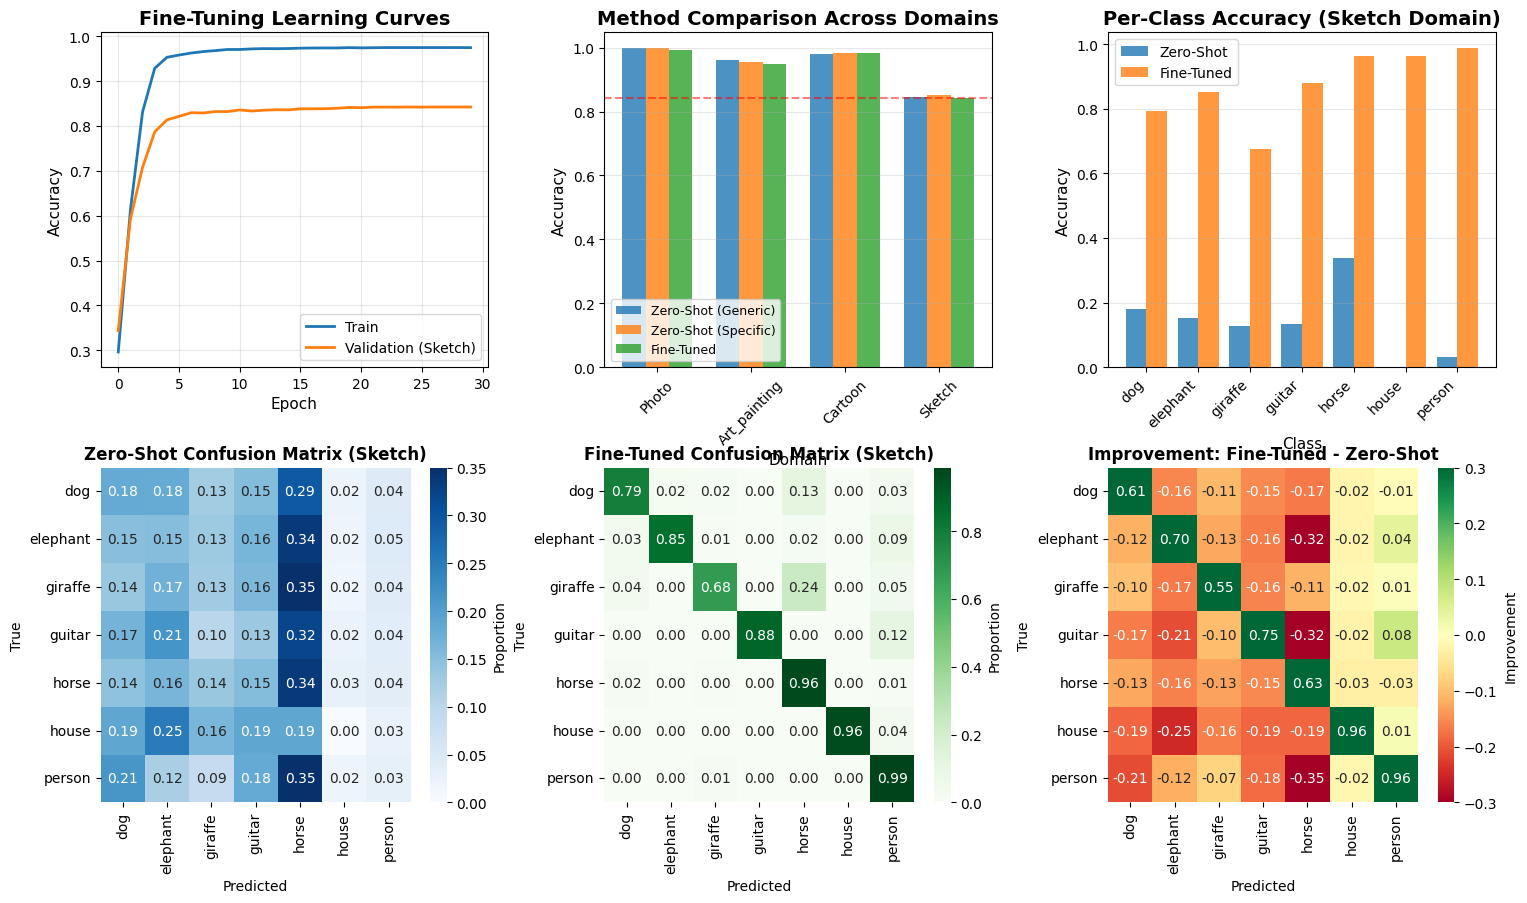


✓ Subtask 3.1 complete! Results saved to /content/drive/MyDrive/ATML_Task3_Results


In [ ]:
# Cell 2: Evaluate and Compare Zero-Shot vs Fine-Tuned
def evaluate_model(model, loader, device):
    """Comprehensive evaluation"""
    model.eval()
    all_preds = []
    all_labels = []
    all_features = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)

            # Get features before classifier
            if hasattr(model, 'clip_model'):
                features = model.clip_model.encode_image(images)
                features = features / features.norm(dim=-1, keepdim=True)
                # Ensure features are float32 for the linear classifier
                outputs = model.classifier(features.float())
            else:
                outputs = model(images)
                features = None

            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            if features is not None:
                all_features.append(features.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return {
        'accuracy': accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'features': np.vstack(all_features) if all_features else None
    }


# Evaluate fine-tuned model on all domains
print("\n" + "="*50)
print("EVALUATING FINE-TUNED MODEL ON ALL DOMAINS")
print("="*50)

finetuned_results = {}
for domain, loader in all_loaders.items():
    print(f"\nEvaluating on {domain}...")
    results = evaluate_model(linear_probe_model, loader, device)
    finetuned_results[domain] = results
    print(f"{domain}: {results['accuracy']:.4f}")

# Create comprehensive comparison
comparison_df = pd.DataFrame({
    'Domain': DOMAINS,
    'Zero-Shot (Generic)': [zero_shot_results[f"{d}_generic"]['accuracy'] for d in DOMAINS],
    'Zero-Shot (Domain-Specific)': [zero_shot_results[f"{d}_specific"]['accuracy'] for d in DOMAINS],
    'Fine-Tuned (Linear Probe)': [finetuned_results[d]['accuracy'] for d in DOMAINS],
})

comparison_df['Best Method'] = comparison_df[['Zero-Shot (Generic)', 'Zero-Shot (Domain-Specific)',
                                               'Fine-Tuned (Linear Probe)']].idxmax(axis=1)

print("\n" + "="*50)
print("COMPREHENSIVE COMPARISON")
print("="*50)
print(comparison_df.to_string(index=False))

# Calculate per-class accuracy for target domain
sketch_labels = finetuned_results['Sketch']['labels']
sketch_preds = finetuned_results['Sketch']['predictions']
sketch_zero_preds = zero_shot_results['Sketch_specific']['predictions']

per_class_acc_ft = []
per_class_acc_zs = []
for i, class_name in enumerate(PACS_CLASSES):
    mask = sketch_labels == i
    if mask.sum() > 0:
        acc_ft = (sketch_preds[mask] == i).mean()
        acc_zs = (sketch_zero_preds[mask] == i).mean()
        per_class_acc_ft.append(acc_ft)
        per_class_acc_zs.append(acc_zs)

# Visualizations
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Training curves
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_hist['acc'], label='Train', linewidth=2)
ax1.plot(val_hist['acc'], label='Validation (Sketch)', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Fine-Tuning Learning Curves', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Domain-wise comparison
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(DOMAINS))
width = 0.25
ax2.bar(x - width, comparison_df['Zero-Shot (Generic)'], width, label='Zero-Shot (Generic)', alpha=0.8)
ax2.bar(x, comparison_df['Zero-Shot (Domain-Specific)'], width, label='Zero-Shot (Specific)', alpha=0.8)
ax2.bar(x + width, comparison_df['Fine-Tuned (Linear Probe)'], width, label='Fine-Tuned', alpha=0.8)
ax2.set_xlabel('Domain', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Method Comparison Across Domains', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(DOMAINS, rotation=45)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=comparison_df.loc[comparison_df['Domain'] == 'Sketch', 'Fine-Tuned (Linear Probe)'].iloc[0], color='red',
            linestyle='--', alpha=0.5, label='Target Performance')

# 3. Per-class accuracy on Sketch
ax3 = fig.add_subplot(gs[0, 2])
x_classes = np.arange(len(PACS_CLASSES))
ax3.bar(x_classes - 0.2, per_class_acc_zs, 0.4, label='Zero-Shot', alpha=0.8)
ax3.bar(x_classes + 0.2, per_class_acc_ft, 0.4, label='Fine-Tuned', alpha=0.8)
ax3.set_xlabel('Class', fontsize=11)
ax3.set_ylabel('Accuracy', fontsize=11)
ax3.set_title('Per-Class Accuracy (Sketch Domain)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_classes)
ax3.set_xticklabels(PACS_CLASSES, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Confusion matrix - Zero-shot
ax4 = fig.add_subplot(gs[1, 0])
cm_zs = confusion_matrix(sketch_labels, sketch_zero_preds)
cm_zs_norm = cm_zs.astype('float') / cm_zs.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_zs_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=PACS_CLASSES, yticklabels=PACS_CLASSES, ax=ax4, cbar_kws={'label': 'Proportion'})
ax4.set_title('Zero-Shot Confusion Matrix (Sketch)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Predicted', fontsize=10)
ax4.set_ylabel('True', fontsize=10)

# 5. Confusion matrix - Fine-tuned
ax5 = fig.add_subplot(gs[1, 1])
cm_ft = confusion_matrix(sketch_labels, sketch_preds)
cm_ft_norm = cm_ft.astype('float') / cm_ft.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_ft_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=PACS_CLASSES, yticklabels=PACS_CLASSES, ax=ax5, cbar_kws={'label': 'Proportion'})
ax5.set_title('Fine-Tuned Confusion Matrix (Sketch)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Predicted', fontsize=10)
ax5.set_ylabel('True', fontsize=10)

# 6. Difference heatmap
ax6 = fig.add_subplot(gs[1, 2])
diff_cm = cm_ft_norm - cm_zs_norm
sns.heatmap(diff_cm, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            xticklabels=PACS_CLASSES, yticklabels=PACS_CLASSES, ax=ax6,
            cbar_kws={'label': 'Improvement'}, vmin=-0.3, vmax=0.3)
ax6.set_title('Improvement: Fine-Tuned - Zero-Shot', fontsize=12, fontweight='bold')
ax6.set_xlabel('Predicted', fontsize=10)
ax6.set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.savefig(f"{output_dir}/subtask3.1_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Save comparison table
comparison_df.to_csv(f"{output_dir}/subtask3.1_method_comparison.csv", index=False)

print(f"\n✓ Subtask 3.1 complete! Results saved to {output_dir}")

# Subtask 3.2: Prompt Learning with CLIP


In [7]:
# =========================
# Subtask 3.2: Prompt Learning (CoOp-style)
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd

# Assumes you already have:
# - device
# - PACS_CLASSES (list of class names in your fixed order)
# - all_loaders (from your unified get_pacs_loaders, so labels are consistent)
# - clip (import clip; model, preprocess = clip.load("ViT-B/32", device=device))

# ---------- Prompt Learner ----------
class PromptLearner(nn.Module):
    """
    CoOp-style learnable context tokens inserted before the class name tokens.
    Supports:
      - class_specific=True: distinct context per class (stronger in-distribution)
      - class_specific=False: one shared context for all classes (often better OOD)
    """
    def __init__(self, clip_model, class_names, n_ctx=16, ctx_init=None, class_specific=True):
        super().__init__()
        self.class_names = class_names
        self.class_specific = class_specific

        # CLIP text encoder sizes / dtype
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]  # text hidden size
        embed = clip_model.token_embedding  # nn.Embedding

        # Tokenize classnames ("dog", "elephant", ...)
        # We'll create prompts like: [SOS] [CTX x n_ctx] <class name tokens> [EOS]
        tokenized = clip.tokenize(class_names).to(device)  # (n_cls, 77)
        with torch.no_grad():
            embedding = embed(tokenized).type(dtype)       # (n_cls, 77, ctx_dim)

        n_cls = len(class_names)
        self.n_cls = n_cls
        self.n_ctx = n_ctx

        # Build prefix/suffix: we keep [SOS] as prefix; we keep the class name + EOS as suffix.
        # We'll find the length of each class name token span (excluding EOS).
        # In CLIP tokenization, the first token is SOS. We place ctx after SOS.
        # name_lens: number of tokens for the class name itself
        self.name_lens = []
        for i in range(n_cls):
            # heuristic: count non-zero, non-EOS tokens after first position
            # stop when we hit the first 0 (padding) or the EOS token (49407)
            row = tokenized[i]
            # SOS at idx0, EOS is 49407
            eos_pos = (row == 49407).nonzero(as_tuple=True)[0]
            eos_pos = eos_pos[0].item() if len(eos_pos) > 0 else 77
            # class name length ~ from 1 to eos_pos-1
            name_len = max(1, eos_pos - 1)
            self.name_lens.append(name_len)

        # Prefix is SOS; suffix = from position 1+name_len to end (includes EOS)
        # We will use the first row as template for SOS/EOS since they’re identical token ids across rows
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS per class for shape convenience
        # Suffix starts at position 1+name_len; but that varies per class, so we’ll slice per-class in forward
        self.register_buffer("embedding", embedding)               # full embedding as reference
        self.register_buffer("tokenized", tokenized)

        # Context init:
        if ctx_init:
            # If you pass words, we tokenize once, take their embeddings, average or slice
            init_tokenized = clip.tokenize(ctx_init).to(device)
            with torch.no_grad():
                init_emb = embed(init_tokenized).type(dtype)  # (1, 77, ctx_dim)
            # Use first n_ctx tokens after SOS as initialization; fall back to random if too short
            ctx = init_emb[:, 1:1+n_ctx, :].clone()
            if ctx.size(1) < n_ctx:
                pad = torch.randn(1, n_ctx - ctx.size(1), ctx_dim, device=device, dtype=dtype) * 0.02
                ctx = torch.cat([ctx, pad], dim=1)
            else:
                ctx = torch.randn(1, n_ctx, ctx_dim, device=device, dtype=torch.float32) * 0.02  # <- FP32
            if class_specific:
                self.ctx = nn.Parameter(ctx.repeat(n_cls, 1, 1))      # (n_cls, n_ctx, dim), FP32 leaf
            else:
                self.ctx = nn.Parameter(ctx)

        # Keep params in fp32 for stable optimization; cast on the fly
        self.fp32 = True

    def forward(self):
        """
        Returns a (n_cls, 77, ctx_dim) tensor of token embeddings ready for CLIP.encode_text.
        """
        dtype = self.embedding.dtype
        n_cls = self.n_cls
        n_ctx = self.n_ctx

        if self.class_specific:
            # (n_cls, n_ctx, ctx_dim)
            ctx = self.ctx
        else:
            # (1, n_ctx, ctx_dim) -> tile to (n_cls, n_ctx, ctx_dim)
            # ctx = self.ctx.repeat(n_cls, 1, 1)
            ctx = self.ctx.expand(n_cls, n_ctx, -1)

        # Cast to model dtype when feeding into CLIP
        ctx = ctx.to(dtype)

        # Build prompts per class: [SOS] [CTX] [class name tokens] [EOS ... padding]
        prompts = []
        for i in range(n_cls):
            # SOS per class row
            prefix = self.token_prefix[i:i+1, :, :]    # (1,1,dim)
            # class name span: positions 1..name_len
            name_len = self.name_lens[i]
            name_tokens = self.embedding[i:i+1, 1:1+name_len, :]  # (1,name_len,dim)
            # suffix: from 1+name_len .. end (includes EOS + padding)
            suffix = self.embedding[i:i+1, 1+name_len:, :]        # (1, 77-1-name_len, dim)
            # concat: SOS, CTX, name, suffix
            prompt = torch.cat([prefix, ctx[i:i+1], name_tokens, suffix], dim=1)
            # If we overflow 77, cut to 77; if shorter, right-pad from the suffix we already included
            prompt = prompt[:, :77, :]
            if prompt.size(1) < 77:
                pad = torch.zeros(1, 77 - prompt.size(1), prompt.size(2), device=prompt.device, dtype=prompt.dtype)
                prompt = torch.cat([prompt, pad], dim=1)
            prompts.append(prompt)
        prompts = torch.cat(prompts, dim=0)  # (n_cls, 77, dim)
        return prompts

# ---------- Wrapper model that uses learned prompts ----------
class CoOpCLIP(nn.Module):
    def __init__(self, clip_model, class_names, n_ctx=16, ctx_init=None, class_specific=True, freeze_image=True, freeze_text=True):
        super().__init__()
        self.clip = clip_model
        if freeze_image:
            for p in self.clip.visual.parameters(): p.requires_grad = False
        if freeze_text:
            for p in self.clip.transformer.parameters(): p.requires_grad = False
            self.clip.token_embedding.weight.requires_grad = False
            self.clip.ln_final.weight.requires_grad = False
            self.clip.ln_final.bias.requires_grad = False

        self.prompt_learner = PromptLearner(
            clip_model=self.clip, class_names=class_names, n_ctx=n_ctx,
            ctx_init=ctx_init, class_specific=class_specific
        )

    def encode_text(self, prompts):
        # CLIP expects (N, 77, dim) embeddings? No—CLIP takes token ids normally,
        # but we can pass embeddings via a small hack: we’ll use the text encoder internals.
        # Safer route: use CLIP’s text encoder on these embeddings via transformer + ln_final.
        x = prompts + self.clip.positional_embedding.type(prompts.dtype)  # (n_cls,77,dim)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.clip.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip.ln_final(x)
        # Take features at the EOS token position (the highest token id 49407 in the original tokenized)
        # Here we mimic CLIP: they take text features of the EOS (last token)
        eos_ind = (self.prompt_learner.tokenized == 49407).float().argmax(dim=1)  # (n_cls,)
        # Gather per class
        text_features = x[torch.arange(x.size(0)), eos_ind] @ self.clip.text_projection
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features

    @torch.no_grad()
    def encode_image(self, images):
        feats = self.clip.encode_image(images)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        return feats

    def forward(self, images):
        prompts = self.prompt_learner()                  # (n_cls,77,dim)
        text_features = self.encode_text(prompts)        # (n_cls, dim)
        image_features = self.encode_image(images)       # (B, dim)
        logits = 100.0 * image_features @ text_features.t()
        return logits

# ---------- Training ----------
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.05): super().__init__(); self.eps = eps
    def forward(self, logits, target):
        n = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        loss = -logp.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = (1 - self.eps) * loss - self.eps * logp.mean(dim=-1)
        return loss.mean()

@torch.no_grad()
def eval_acc_prompt(model, loader):
    model.eval()
    tot = cor = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(1)
        cor += (pred==y).sum().item()
        tot += y.size(0)
    return cor / max(1, tot)

def train_prompt(model, source_loaders, target_loader=None, num_epochs=10, lr=0.002, lambda_entropy=0.0):
    """
    Train only the prompt context parameters on source domains.
    Optionally add target entropy minimization with weight lambda_entropy.
    """
    # params = [p for p in model.prompt_learner.parameters() if p.requires_grad]
    # # Keep optimizer fp32 even if CLIP runs in fp16
    # for p in params:
    #     if p.dtype != torch.float32:
    #         p.data = p.data.float()
    #         p.requires_grad = True
    # optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)
    params = list(model.prompt_learner.parameters())  # contains FP32 ctx
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = LabelSmoothingCE(eps=0.05)

    best_acc = 0.0
    best_state = None
    hist = {'train_acc': [], 'val_acc': []}

    for ep in range(num_epochs):
        model.train()  # only prompt_learner has grads
        # iterate all source domains (skip Sketch)
        running_correct = running_total = 0
        for dom, loader in source_loaders.items():
            if dom.lower() == 'sketch':  # safety
                continue
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad(set_to_none=True)
                logits = model(x)
                loss = criterion(logits, y)

                # optional: target entropy minimization for unsupervised target data
                if lambda_entropy > 0.0 and target_loader is not None:
                    try:
                        xt, _ = next(target_loader_iter)
                    except:
                        target_loader_iter = iter(target_loader)
                        xt, _ = next(target_loader_iter)
                    xt = xt.to(device)
                    with torch.no_grad():
                        logits_t = model(xt)
                        pt = F.softmax(logits_t, dim=-1)
                    ent = -(pt * (pt.clamp_min(1e-9).log())).sum(dim=1).mean()
                    loss = loss + lambda_entropy * ent  # minimize entropy

                loss.backward()
                optimizer.step()

                running_total += y.size(0)
                running_correct += (logits.argmax(1) == y).sum().item()

        train_acc = running_correct / max(1, running_total)
        # validate on Sketch if provided, else on first source
        if target_loader is not None:
            val_acc = eval_acc_prompt(model, target_loader)
        else:
            # pick one domain to monitor, e.g., Photo
            any_loader = list(source_loaders.values())[0]
            val_acc = eval_acc_prompt(model, any_loader)

        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if (ep+1) % 5 == 0:
            print(f"[CoOp ep {ep+1}] train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

        scheduler.step()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist, best_acc


In [ ]:
# ---------- Build data splits for CoOp ----------
# Source = Photo, Art_painting, Cartoon ; Target = Sketch
source_loaders_prompt = {k:v for k,v in all_loaders.items() if k != "Sketch"}
target_loader_prompt  = all_loaders["Sketch"]

# ---------- Run both variants ----------
import clip
clip_model_coop_cs, _ = clip.load("ViT-B/32", device=device)
clip_model_coop_sh, _ = clip.load("ViT-B/32", device=device)

# A) Class-specific (strongest in-distribution)
coop_cs = CoOpCLIP(clip_model_coop_cs, PACS_CLASSES, n_ctx=16, ctx_init=None, class_specific=True).to(device)
coop_cs, hist_cs, best_cs = train_prompt(coop_cs, source_loaders_prompt, target_loader_prompt, num_epochs=20, lr=0.002, lambda_entropy=0.0)
print(f"Best Sketch acc (class-specific): {best_cs:.4f}")

# B) Shared-context (often better when data scarce / for generalization)
coop_sh = CoOpCLIP(clip_model_coop_sh, PACS_CLASSES, n_ctx=16, ctx_init=None, class_specific=False).to(device)
coop_sh, hist_sh, best_sh = train_prompt(coop_sh, source_loaders_prompt, target_loader_prompt, num_epochs=20, lr=0.002, lambda_entropy=0.0)
print(f"Best Sketch acc (shared-context): {best_sh:.4f}")

# ---------- Evaluate on all domains ----------
@torch.no_grad()
def eval_all_domains_prompt(model, loaders):
    model.eval()
    out = {}
    for dom, loader in loaders.items():
        acc = eval_acc_prompt(model, loader)
        out[dom] = {'accuracy': acc}
    return out

results_coop_cs = eval_all_domains_prompt(coop_cs, all_loaders)
results_coop_sh = eval_all_domains_prompt(coop_sh, all_loaders)

# Make a comparison table (optionally compare to your zero-shot & linear-probe if you have dicts)
df_coop = pd.DataFrame({
    'Domain': DOMAINS,
    'CoOp (class-specific)': [results_coop_cs[d]['accuracy'] for d in DOMAINS],
    'CoOp (shared)':         [results_coop_sh[d]['accuracy'] for d in DOMAINS],
})
print(df_coop)

[CoOp ep 5] train_acc=0.990 | val_acc=0.813
[CoOp ep 10] train_acc=0.995 | val_acc=0.821
[CoOp ep 15] train_acc=0.998 | val_acc=0.841
[CoOp ep 20] train_acc=0.998 | val_acc=0.843
Best Sketch acc (class-specific): 0.8442
[CoOp ep 5] train_acc=0.158 | val_acc=0.196
[CoOp ep 10] train_acc=0.158 | val_acc=0.196
[CoOp ep 15] train_acc=0.158 | val_acc=0.196
[CoOp ep 20] train_acc=0.158 | val_acc=0.196
Best Sketch acc (shared-context): 0.1965
         Domain  CoOp (class-specific)  CoOp (shared)
0         Photo               1.000000       0.113174
1  Art_painting               0.998535       0.185059
2       Cartoon               0.997440       0.165956
3        Sketch               0.844235       0.196488


In [10]:
# Source = Photo, Art_painting, Cartoon ; Target = Sketch
source_loaders_prompt = {k:v for k,v in all_loaders.items() if k != "Sketch"}
target_loader_prompt  = all_loaders["Sketch"]

clip_model_coop_sh_, _ = clip.load("ViT-B/32", device=device)
coop_sh = CoOpCLIP(clip_model_coop_sh_, PACS_CLASSES, n_ctx=16,ctx_init="a photo of a", class_specific=False).to(device)

# shared
coop_sh, hist_sh, best_sh = train_prompt(coop_sh, source_loaders_prompt,target_loader_prompt, num_epochs=30, lr=0.005)
print(f"Best Sketch acc (shared-context): {best_sh:.4f}")

results_coop_sh = eval_all_domains_prompt(coop_sh, all_loaders)

# Make a comparison table (optionally compare to your zero-shot & linear-probe if you have dicts)
df_coop = pd.DataFrame({
    'Domain': DOMAINS,
    'CoOp (shared)':         [results_coop_sh[d]['accuracy'] for d in DOMAINS],
})
print(df_coop)




[CoOp ep 5] train_acc=0.158 | val_acc=0.196
[CoOp ep 10] train_acc=0.158 | val_acc=0.196
[CoOp ep 15] train_acc=0.158 | val_acc=0.196
[CoOp ep 20] train_acc=0.158 | val_acc=0.196


KeyboardInterrupt: 


EVALUATING PROMPT LEARNING MODELS

      Domain  Zero-Shot  Fine-Tuned  Prompt (Variant A)  Prompt (Variant B)
       Photo   0.998204    0.994012            1.000000            0.113174
Art_painting   0.956543    0.948242            0.998535            0.185059
     Cartoon   0.982082    0.983362            0.997440            0.165956
      Sketch   0.850853    0.842199            0.844490            0.196488

Avg cosine to Zero-Shot text head — Variant A: 0.4333 | Variant B: 0.3716


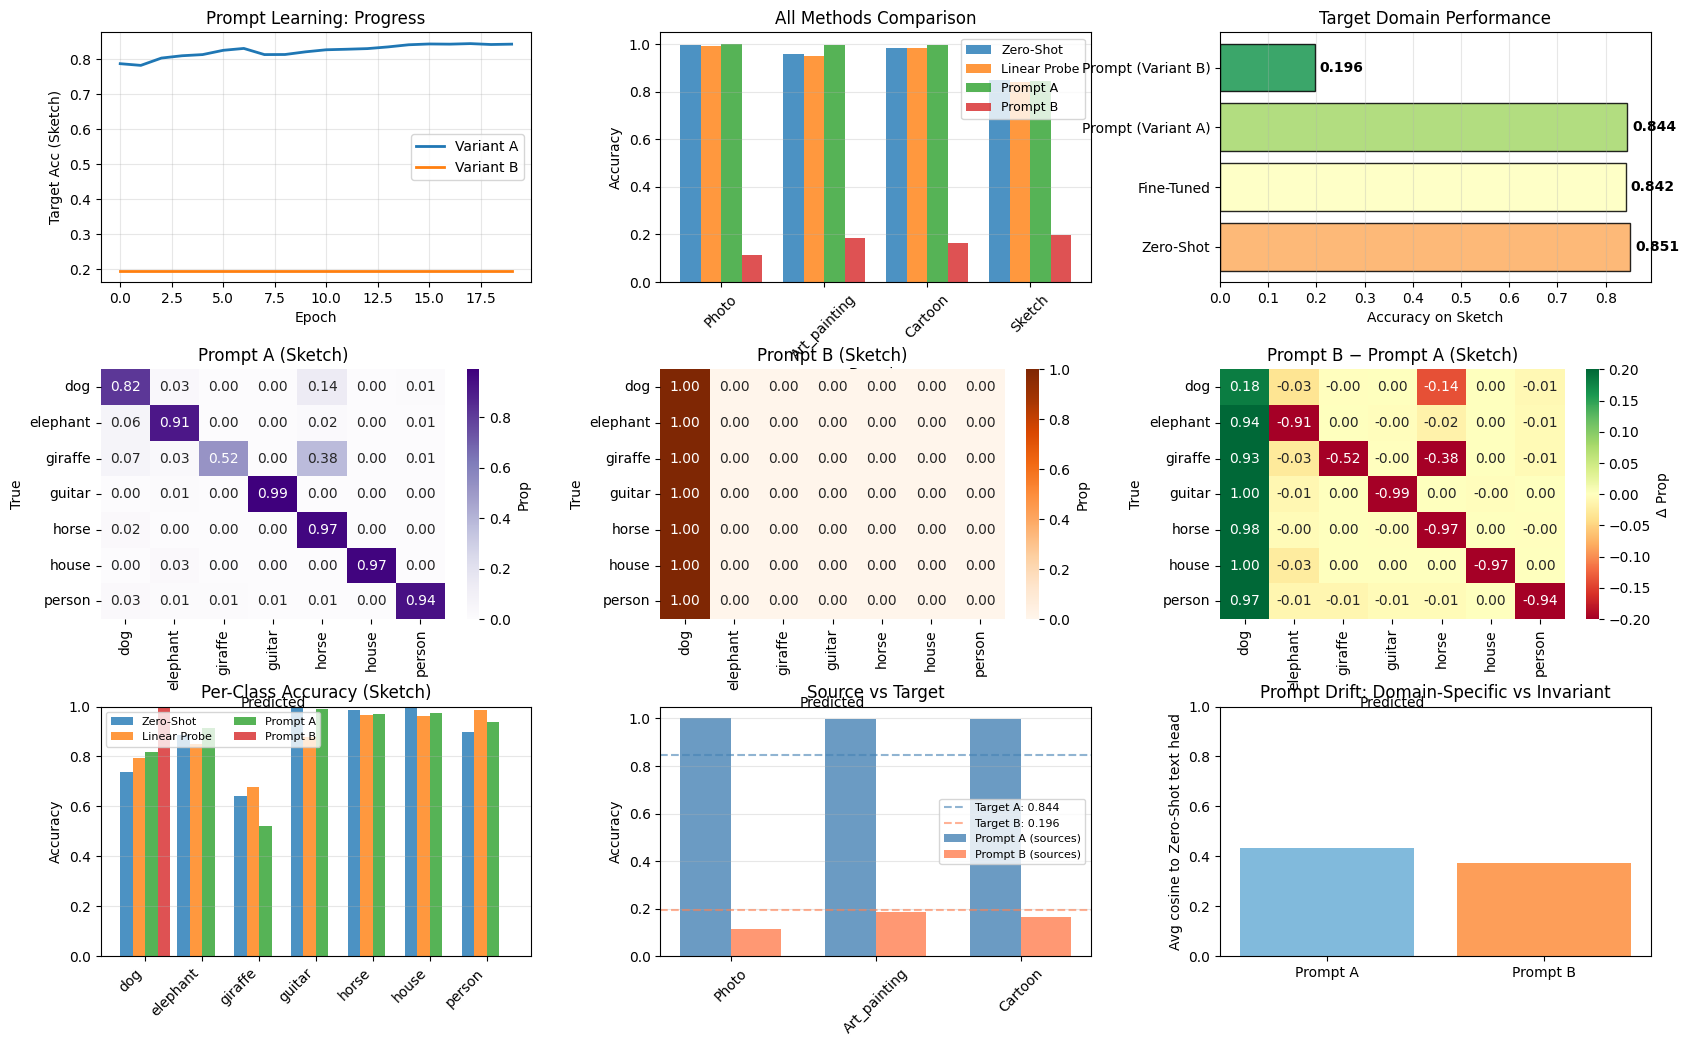


✓ Subtask 3.2 complete! Results saved to /content/drive/MyDrive/ATML_Task3_Results


In [ ]:
# ===== Subtask 3.2 — Robust Evaluation for Prompt Learning (CoOp) =====
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# --- utilities ---
def build_text_features_from_model(prompt_model):
    """Use the prompt model's current learned prompts to produce normalized text features (C,D)."""
    prompt_model.eval()
    with torch.no_grad():
        prompts = prompt_model.prompt_learner()             # (C,77,dim)
        text_feats = prompt_model.encode_text(prompts)      # (C,D)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    return text_feats

@torch.no_grad()
def eval_prompt_on_loader(prompt_model, loader, text_feats, device):
    """
    Evaluate a CoOp prompt model on one loader.
    Uses encode_image + provided text_feats (C,D) to compute logits and predictions.
    Returns preds, labels, accuracy. (No feature-stacking to keep memory modest.)
    """
    prompt_model.eval()
    all_preds, all_labels = [], []
    for images, labels in loader:
        images = images.to(device)
        img = prompt_model.encode_image(images)             # (B,D), already normalized
        logits = 100.0 * img @ text_feats.t()               # (B,C)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(list(preds))
        all_labels.extend(list(labels.numpy()))
    all_preds = np.array(all_preds); all_labels = np.array(all_labels)
    acc = (all_preds == all_labels).mean()
    return all_preds, all_labels, acc

def evaluate_prompt_model(prompt_model, loaders, device):
    """Evaluate a prompt model on all domains; returns dict per domain with preds/labels/acc."""
    text_feats = build_text_features_from_model(prompt_model)   # (C,D)
    results = {}
    for domain, loader in loaders.items():
        preds, labels, acc = eval_prompt_on_loader(prompt_model, loader, text_feats, device)
        results[domain] = {'accuracy': acc, 'predictions': preds, 'labels': labels}
    return results, text_feats

def per_class_acc(labels, preds, num_classes):
    out = []
    for c in range(num_classes):
        m = (labels == c)
        out.append((preds[m] == c).mean() if m.sum() > 0 else np.nan)
    return np.array(out, float)

# ---- Evaluate both prompt models (class-specific vs shared / or source-only vs +entropy) ----
print("\n" + "="*50)
print("EVALUATING PROMPT LEARNING MODELS")
print("="*50)

#
prompt_model_source = coop_cs   # class-specific CoOp (variant A)
prompt_model_target = coop_sh   # shared-context CoOp (variant B)

results_prompt_source, text_feats_src = evaluate_prompt_model(prompt_model_source, all_loaders, device)
results_prompt_target, text_feats_tgt = evaluate_prompt_model(prompt_model_target, all_loaders, device)

# ---- Comparison table (add zero-shot + linear probe if you computed them earlier) ----
prompt_comparison = pd.DataFrame({
    'Domain': DOMAINS,
    'Zero-Shot': [zero_shot_results[f"{d}_specific"]['accuracy'] for d in DOMAINS],
    'Fine-Tuned': [finetuned_results[d]['accuracy'] for d in DOMAINS],
    'Prompt (Variant A)': [results_prompt_source[d]['accuracy'] for d in DOMAINS],
    'Prompt (Variant B)': [results_prompt_target[d]['accuracy'] for d in DOMAINS],
})
print("\n" + prompt_comparison.to_string(index=False))

# ---- Prompt drift analysis: similarity to generic zero-shot head (domain-specific prompts) ----
def build_zeroshot_head(clip_model, class_names, prompt_templates, device):
    with torch.no_grad():
        feats = []
        for tpl in prompt_templates:
            texts = [tpl.format(c) for c in class_names]
            toks = clip.tokenize(texts).to(device)
            tf = clip_model.encode_text(toks)
            tf = tf / tf.norm(dim=-1, keepdim=True)
            feats.append(tf)
        tf = torch.stack(feats).mean(0)
        tf = tf / tf.norm(dim=-1, keepdim=True)
    return tf

zs_templates_sketch = ["a sketch of a {}.","a drawing of a {}.","a pencil sketch of a {}."]
zs_head = build_zeroshot_head(model, PACS_CLASSES, zs_templates_sketch, device)  # (C,D)

@torch.no_grad()
def cosine_avg(a, b):  # a,b: (C,D) tensors
    a = a / a.norm(dim=-1, keepdim=True); b = b / b.norm(dim=-1, keepdim=True)
    return (a * b).sum(dim=-1).mean().item()

sim_src_to_zs = cosine_avg(text_feats_src, zs_head)
sim_tgt_to_zs = cosine_avg(text_feats_tgt, zs_head)
print(f"\nAvg cosine to Zero-Shot text head — Variant A: {sim_src_to_zs:.4f} | Variant B: {sim_tgt_to_zs:.4f}")

# ---- Per-class on Sketch (each model uses its own labels) ----
NUM_CLASSES = len(PACS_CLASSES)
zs_labels = zero_shot_results['Sketch_specific']['labels']
zs_preds  = zero_shot_results['Sketch_specific']['predictions']
ft_labels = finetuned_results['Sketch']['labels']
ft_preds  = finetuned_results['Sketch']['predictions']
src_labels = results_prompt_source['Sketch']['labels']
src_preds  = results_prompt_source['Sketch']['predictions']
tgt_labels = results_prompt_target['Sketch']['labels']
tgt_preds  = results_prompt_target['Sketch']['predictions']

pcs_zs  = per_class_acc(zs_labels,  zs_preds,  NUM_CLASSES)
pcs_ft  = per_class_acc(ft_labels,  ft_preds,  NUM_CLASSES)
pcs_src = per_class_acc(src_labels, src_preds, NUM_CLASSES)
pcs_tgt = per_class_acc(tgt_labels, tgt_preds, NUM_CLASSES)

# ---- Confusions (Sketch) ----
cm_src = confusion_matrix(src_labels, src_preds)
cm_tgt = confusion_matrix(tgt_labels, tgt_preds)
cm_src_n = cm_src.astype(float) / cm_src.sum(axis=1, keepdims=True)
cm_tgt_n = cm_tgt.astype(float) / cm_tgt.sum(axis=1, keepdims=True)

# =======================
# Plots (safe-guarded)
# =======================
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1) (Optional) training curves if available
ax1 = fig.add_subplot(gs[0,0])
# Check if histories exist and are dictionaries with the expected keys
has_hist_A = 'hist_cs' in globals() and isinstance(hist_cs, dict) and 'val_acc' in hist_cs
has_hist_B = 'hist_sh' in globals() and isinstance(hist_sh, dict) and 'val_acc' in hist_sh

if has_hist_A: ax1.plot(hist_cs['val_acc'], label='Variant A', linewidth=2)
if has_hist_B: ax1.plot(hist_sh['val_acc'], label='Variant B', linewidth=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Target Acc (Sketch)'); ax1.set_title('Prompt Learning: Progress')
ax1.legend(); ax1.grid(alpha=0.3)


# 2) Method comparison across domains
ax2 = fig.add_subplot(gs[0,1])
x = np.arange(len(DOMAINS)); w = 0.2
ax2.bar(x - 1.5*w, prompt_comparison['Zero-Shot'], w, label='Zero-Shot', alpha=0.8)
ax2.bar(x - 0.5*w, prompt_comparison['Fine-Tuned'], w, label='Linear Probe', alpha=0.8)
ax2.bar(x + 0.5*w, prompt_comparison['Prompt (Variant A)'], w, label='Prompt A', alpha=0.8)
ax2.bar(x + 1.5*w, prompt_comparison['Prompt (Variant B)'], w, label='Prompt B', alpha=0.8)
ax2.set_xlabel('Domain'); ax2.set_ylabel('Accuracy'); ax2.set_title('All Methods Comparison')
ax2.set_xticks(x); ax2.set_xticklabels(DOMAINS, rotation=45); ax2.legend(fontsize=9); ax2.grid(axis='y', alpha=0.3)

# 3) Target domain bar
ax3 = fig.add_subplot(gs[0,2])
methods = ['Zero-Shot','Fine-Tuned','Prompt (Variant A)','Prompt (Variant B)'] # Corrected method names
sk_vals = [prompt_comparison.loc[prompt_comparison['Domain']=='Sketch', m].values[0] for m in methods]
bars = ax3.barh(methods, sk_vals, color=plt.cm.RdYlGn(np.linspace(0.3,0.9,len(methods))), alpha=0.85, edgecolor='black')
ax3.set_xlabel('Accuracy on Sketch'); ax3.set_title('Target Domain Performance'); ax3.grid(axis='x', alpha=0.3)
for i,(b,val) in enumerate(zip(bars, sk_vals)): ax3.text(val+0.01, i, f'{val:.3f}', va='center', fontweight='bold')

# 4) Confusion matrices (Sketch)
ax4 = fig.add_subplot(gs[1,0]); sns.heatmap(cm_src_n, annot=True, fmt='.2f', cmap='Purples',
    xticklabels=PACS_CLASSES, yticklabels=PACS_CLASSES, ax=ax4, cbar_kws={'label':'Prop'})
ax4.set_title('Prompt A (Sketch)'); ax4.set_xlabel('Predicted'); ax4.set_ylabel('True')

ax5 = fig.add_subplot(gs[1,1]); sns.heatmap(cm_tgt_n, annot=True, fmt='.2f', cmap='Oranges',
    xticklabels=PACS_CLASSES, yticklabels=PACS_CLASSES, ax=ax5, cbar_kws={'label':'Prop'})
ax5.set_title('Prompt B (Sketch)'); ax5.set_xlabel('Predicted'); ax5.set_ylabel('True')

# 5) Difference heatmap
ax6 = fig.add_subplot(gs[1,2]); diff = cm_tgt_n - cm_src_n
sns.heatmap(diff, annot=True, fmt='.2f', cmap='RdYlGn', center=0, vmin=-0.2, vmax=0.2,
    xticklabels=PACS_CLASSES, yticklabels=PACS_CLASSES, ax=ax6, cbar_kws={'label':'Δ Prop'})
ax6.set_title('Prompt B − Prompt A (Sketch)'); ax6.set_xlabel('Predicted'); ax6.set_ylabel('True')

# 6) Per-class on Sketch
ax8 = fig.add_subplot(gs[2,0])
x_cls = np.arange(len(PACS_CLASSES)); w = 0.22
ax8.bar(x_cls - 1.5*w, pcs_zs,  w, label='Zero-Shot', alpha=0.8)
ax8.bar(x_cls - 0.5*w, pcs_ft,  w, label='Linear Probe', alpha=0.8)
ax8.bar(x_cls + 0.5*w, pcs_src, w, label='Prompt A', alpha=0.8)
ax8.bar(x_cls + 1.5*w, pcs_tgt, w, label='Prompt B', alpha=0.8)
ax8.set_xticks(x_cls); ax8.set_xticklabels(PACS_CLASSES, rotation=45, ha='right')
ax8.set_ylim(0,1.0); ax8.set_ylabel('Accuracy'); ax8.set_title('Per-Class Accuracy (Sketch)')
ax8.legend(ncol=2, fontsize=8); ax8.grid(axis='y', alpha=0.3)

# 7) Source vs Target (overfitting view)
ax9 = fig.add_subplot(gs[2,1])
source_domains = [d for d in DOMAINS if d != 'Sketch']
srcA = [results_prompt_source[d]['accuracy'] for d in source_domains]
srcB = [results_prompt_target[d]['accuracy'] for d in source_domains]
tA = results_prompt_source['Sketch']['accuracy']; tB = results_prompt_target['Sketch']['accuracy']
xx = np.arange(len(source_domains)); w = 0.35
ax9.bar(xx - w/2, srcA, w, label='Prompt A (sources)', alpha=0.8, color='steelblue')
ax9.bar(xx + w/2, srcB, w, label='Prompt B (sources)', alpha=0.8, color='coral')
ax9.axhline(y=tA, color='steelblue', linestyle='--', alpha=0.6, label=f'Target A: {tA:.3f}')
ax9.axhline(y=tB, color='coral', linestyle='--', alpha=0.6, label=f'Target B: {tB:.3f}')
ax9.set_xticks(xx); ax9.set_xticklabels(source_domains, rotation=45)
ax9.set_ylabel('Accuracy'); ax9.set_title('Source vs Target'); ax9.legend(fontsize=8)
ax9.grid(axis='y', alpha=0.3)

# 8) Prompt drift (cosine to zero-shot head)
ax10 = fig.add_subplot(gs[2,2])
ax10.bar(['Prompt A','Prompt B'], [sim_src_to_zs, sim_tgt_to_zs], color=['#6baed6','#fd8d3c'], alpha=0.85)
ax10.set_ylim(0,1.0); ax10.set_ylabel('Avg cosine to Zero-Shot text head')
ax10.set_title('Prompt Drift: Domain-Specific vs Invariant')

plt.savefig(f"{output_dir}/subtask3.2_prompt_learning_comprehensive.png", dpi=300, bbox_inches='tight')
plt.show()

# Save comparison table
prompt_comparison.to_csv(f"{output_dir}/subtask3.2_prompt_comparison.csv", index=False)

print(f"\n✓ Subtask 3.2 complete! Results saved to {output_dir}")

#Subtask 3.3: Gradient Conflict and Alignment


In [14]:
# ===== Subtask 3.3 — Gradient Conflict Analysis with a CoOpLite model (Cell 1) =====
import torch, copy, numpy as np, pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

# ---------------------------------------------------------
# 0) Minimal PromptLearnerLite + CoOpCLIPLite (always has ctx)
# ---------------------------------------------------------
class PromptLearnerLite(nn.Module):
    """
    Minimal CoOp prompt learner with guaranteed trainable ctx.
    class_specific=True => ctx: (C, n_ctx, dim)
    """
    def __init__(self, clip_model, class_names, n_ctx=16, class_specific=True, ctx_init=None, device=None):
        super().__init__()
        self.class_names = class_names
        self.n_cls = len(class_names)
        self.n_ctx = n_ctx
        self.class_specific = class_specific
        self.device = device or next(clip_model.parameters()).device

        self.embed = clip_model.token_embedding            # nn.Embedding
        self.dtype = clip_model.dtype
        # Tokenize classnames once
        tokenized = clip.tokenize(class_names).to(self.device)
        with torch.no_grad():
            emb = self.embed(tokenized).type(self.dtype)   # (C,77,dim)
        self.register_buffer("tokenized", tokenized)
        self.register_buffer("base_embedding", emb)        # (C,77,dim)

        # Find EOS per row + name length (exclude SOS at pos 0)
        eos_token = 49407
        self.name_lens = []
        for i in range(self.n_cls):
            row = tokenized[i]
            eos_pos = (row == eos_token).nonzero(as_tuple=True)[0]
            eos_pos = int(eos_pos[0].item()) if len(eos_pos) else 77
            name_len = max(1, eos_pos - 1)
            self.name_lens.append(name_len)

        # Init ctx (FP32 parameter for stable updates)
        dim = emb.shape[-1]
        if ctx_init is not None:
            init_tok = clip.tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                init_emb = self.embed(init_tok).type(torch.float32)  # (1,77,dim)
            ctx = init_emb[:, 1:1+n_ctx, :].clone()
            if ctx.size(1) < n_ctx:
                pad = torch.randn(1, n_ctx-ctx.size(1), dim, device=self.device, dtype=torch.float32) * 0.02
                ctx = torch.cat([ctx, pad], dim=1)
        else:
            ctx = torch.randn(1, n_ctx, dim, device=self.device, dtype=torch.float32) * 0.02

        if class_specific:
            self.ctx = nn.Parameter(ctx.repeat(self.n_cls, 1, 1))  # (C, n_ctx, dim)
        else:
            self.ctx = nn.Parameter(ctx)                            # (1, n_ctx, dim)

    def forward(self):
        C, n_ctx = self.n_cls, self.n_ctx
        emb = self.base_embedding
        # SOS per class:
        prefix = emb[:, :1, :]                      # (C,1,dim)
        prompts = []
        # expand shared
        if self.class_specific:
            ctx = self.ctx                           # (C,n_ctx,dim)
        else:
            ctx = self.ctx.expand(C, n_ctx, -1)      # (C,n_ctx,dim)
        ctx = ctx.to(emb.dtype)

        for i in range(C):
            name_len = self.name_lens[i]
            name_tokens = emb[i:i+1, 1:1+name_len, :]
            suffix = emb[i:i+1, 1+name_len:, :]
            p = torch.cat([prefix[i:i+1], ctx[i:i+1], name_tokens, suffix], dim=1)
            p = p[:, :77, :]
            if p.size(1) < 77:
                pad = torch.zeros(1, 77-p.size(1), p.size(2), device=p.device, dtype=p.dtype)
                p = torch.cat([p, pad], dim=1)
            prompts.append(p)
        return torch.cat(prompts, dim=0)            # (C,77,dim)

class CoOpCLIPLite(nn.Module):
    """Minimal wrapper around CLIP using PromptLearnerLite."""
    def __init__(self, clip_model, class_names, n_ctx=16, class_specific=True, ctx_init=None, device=None):
        super().__init__()
        self.clip = clip_model
        # freeze encoders
        for p in self.clip.visual.parameters(): p.requires_grad = False
        for p in self.clip.transformer.parameters(): p.requires_grad = False
        self.clip.token_embedding.weight.requires_grad = False
        self.clip.ln_final.weight.requires_grad = False
        self.clip.ln_final.bias.requires_grad = False
        self.prompt_learner = PromptLearnerLite(clip_model, class_names, n_ctx=n_ctx,
                                                class_specific=class_specific, ctx_init=ctx_init, device=device)

    @torch.no_grad()
    def encode_image(self, images):
        x = self.clip.encode_image(images)
        return x / x.norm(dim=-1, keepdim=True)

    def _encode_text_from_emb(self, prompts):
        x = prompts + self.clip.positional_embedding.type(prompts.dtype)
        x = x.permute(1,0,2)               # NLD->LND
        x = self.clip.transformer(x)
        x = x.permute(1,0,2)               # LND->NLD
        x = self.clip.ln_final(x)
        # take EOS position per class
        eos = (self.prompt_learner.tokenized == 49407).float().argmax(dim=1)  # (C,)
        feats = x[torch.arange(x.size(0)), eos] @ self.clip.text_projection
        return feats / feats.norm(dim=-1, keepdim=True)

    def text_features(self):
        prompts = self.prompt_learner()                      # (C,77,dim)
        return self._encode_text_from_emb(prompts)

    def forward(self, images):
        img = self.encode_image(images)                      # (B,D)
        txt = self.text_features()                           # (C,D)
        return 100.0 * img @ txt.t()                         # logits

# ---------------------------------------------------------
# 1) Build loaders to compare source domains (exclude Sketch)
# ---------------------------------------------------------
source_loaders_grad = {k: v for k, v in all_loaders.items() if k != "Sketch"}
grad_domains = list(source_loaders_grad.keys())
assert len(grad_domains) >= 2, "Need ≥2 source domains."

# ---------------------------------------------------------
# 2) Gradient analyzer over prompt parameters
# ---------------------------------------------------------
class GradientAnalyzer:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    @torch.no_grad()
    def one_batch(self, loader):
        it = iter(loader)
        x, y = next(it)
        return x.to(self.device), y.to(self.device)

    def prompt_params(self):
        return [p for n,p in self.model.prompt_learner.named_parameters()
                if p.requires_grad and p.ndim == 3]  # the ctx tensor

    def domain_gradients(self, domain_loaders, criterion):
        self.model.eval()
        params = self.prompt_params()
        out = {}
        for dom, loader in domain_loaders.items():
            x, y = self.one_batch(loader)
            logits = self.model(x)
            loss = criterion(logits, y)
            grads = torch.autograd.grad(loss, params, retain_graph=False, create_graph=False)
            flat = torch.cat([g.flatten() for g in grads])
            out[dom] = flat.detach()
        return out

    @staticmethod
    def cosine(a, b):
        a = a/(a.norm()+1e-12); b=b/(b.norm()+1e-12)
        return float((a*b).sum().item())

    def analyze(self, domain_grads):
        doms = list(domain_grads.keys())
        n = len(doms)
        sim = np.zeros((n,n), np.float32)
        ang = np.zeros((n,n), np.float32)
        for i,di in enumerate(doms):
            for j,dj in enumerate(doms):
                if i==j: sim[i,j]=1.0; ang[i,j]=0.0
                else:
                    c = self.cosine(domain_grads[di], domain_grads[dj])
                    sim[i,j]=c
                    ang[i,j]=float(np.degrees(np.arccos(np.clip(c,-1,1))))
        return sim, ang, doms

def pcgrad_project(grad_list):
    proj=[]
    for i,gi in enumerate(grad_list):
        gi_new = gi.clone()
        for j,gj in enumerate(grad_list):
            if i==j: continue
            cos_ = F.cosine_similarity(gi_new.unsqueeze(0), gj.unsqueeze(0)).item()
            if cos_ < 0:
                gi_new = gi_new - (gi_new @ gj)/(gj @ gj + 1e-12)*gj
        proj.append(gi_new)
    return proj

# ---------------------------------------------------------
# 3) Run analysis at init and across a few epochs (prompt-only)
# ---------------------------------------------------------
print("\n" + "="*50)
print("SUBTASK 3.3: GRADIENT CONFLICT ANALYSIS")
print("="*50)

clip_model_grad, _ = clip.load("ViT-B/32", device=device)
grad_model = CoOpCLIPLite(clip_model_grad, PACS_CLASSES, n_ctx=16, class_specific=True, ctx_init=None, device=device).to(device)

analyzer = GradientAnalyzer(grad_model, device)
criterion = nn.CrossEntropyLoss()

print("\n--- Analyzing at initialization ---")
grads_init = analyzer.domain_gradients(source_loaders_grad, criterion)
sim_matrix_init, angle_matrix_init, domain_names = analyzer.analyze(grads_init)
print(pd.DataFrame(sim_matrix_init, index=domain_names, columns=domain_names).round(3))

optimizer = torch.optim.SGD([p for p in grad_model.prompt_learner.parameters() if p.requires_grad],
                            lr=0.005, momentum=0.9, weight_decay=1e-4)

epochs_to_analyze = [0,5,10,15,20]
gradient_snapshots = {'epoch_0': {'similarity': sim_matrix_init, 'angles': angle_matrix_init}}
conflict_history = {'epoch': [], 'avg_similarity': [], 'min_similarity': [], 'max_conflict_angle': []}

for ep in range(1,21):
    grad_model.train()
    # one batch per source domain (tiny analysis run)
    for dom in domain_names:
        x, y = next(iter(source_loaders_grad[dom]))
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(grad_model(x), y)
        loss.backward()
        optimizer.step()

    if ep in epochs_to_analyze:
        grad_model.eval()
        g_now = analyzer.domain_gradients(source_loaders_grad, criterion)
        sim_now, ang_now, _ = analyzer.analyze(g_now)
        gradient_snapshots[f'epoch_{ep}'] = {'similarity': sim_now, 'angles': ang_now}

        iu = np.triu_indices(len(domain_names), k=1)
        avg_sim = float(sim_now[iu].mean()) if iu[0].size else 1.0
        min_sim = float(sim_now[iu].min()) if iu[0].size else 1.0
        max_ang = float(ang_now[iu].max()) if iu[0].size else 0.0

        conflict_history['epoch'].append(ep)
        conflict_history['avg_similarity'].append(avg_sim)
        conflict_history['min_similarity'].append(min_sim)
        conflict_history['max_conflict_angle'].append(max_ang)

        print(f"[ep {ep}] avg_sim={avg_sim:.3f} | min_sim={min_sim:.3f} | max_angle={max_ang:.1f}°")

print("\n" + "="*50)
print("GRADIENT CONFLICT SUMMARY")
print("="*50)
conflict_df = pd.DataFrame(conflict_history)
print(conflict_df.to_string(index=False))
conflict_df.to_csv(f"{output_dir}/subtask3.3_gradient_conflicts.csv", index=False)

# ---------------------------------------------------------
# 4) PCGrad-style training on sources, evaluate on target (Sketch)
# ---------------------------------------------------------
def flatten_grads(grads):
    return torch.cat([g.flatten() for g in grads])

def assign_flat_grad(flat, params):
    idx=0
    for p in params:
        n = p.numel()
        p.grad = flat[idx:idx+n].view_as(p).clone()
        idx += n

def train_pcgrad(model, source_loaders, target_loader, num_epochs=20, lr=0.005):
    params = [p for p in model.prompt_learner.parameters() if p.requires_grad]
    opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()

    hist = {'target_acc': [], 'avg_gradient_sim': [], 'alignment_applied': []}
    best = 0.0; best_state=None

    for ep in range(1, num_epochs+1):
        model.train()
        # assemble one batch per source
        batches = {d: next(iter(dl)) for d,dl in source_loaders.items()}
        grad_vecs = []
        pair_sims = []
        for d,(x,y) in batches.items():
            x,y = x.to(device), y.to(device)
            logits = model(x); loss = crit(logits,y)
            grads = torch.autograd.grad(loss, params, retain_graph=True)
            grad_vecs.append(flatten_grads(grads))
        # average pairwise similarity (for logging)
        for i in range(len(grad_vecs)):
            for j in range(i+1,len(grad_vecs)):
                gi = grad_vecs[i]/(grad_vecs[i].norm()+1e-12)
                gj = grad_vecs[j]/(grad_vecs[j].norm()+1e-12)
                pair_sims.append(float((gi*gj).sum().item()))
        avg_sim = float(np.mean(pair_sims)) if pair_sims else 1.0

        # PCGrad projection + merge
        if len(grad_vecs) >= 2:
            proj = pcgrad_project(grad_vecs)
            merged = torch.stack(proj, dim=0).mean(0)
            applied = True
        else:
            merged = grad_vecs[0]; applied = False

        opt.zero_grad(set_to_none=True)
        assign_flat_grad(merged, params)
        opt.step()

        # eval on target
        model.eval()
        correct=total=0
        with torch.no_grad():
            for x,y in all_loaders["Sketch"]:
                x,y = x.to(device), y.to(device)
                pred = model(x).argmax(1)
                correct += (pred==y).sum().item(); total += y.size(0)
        acc = correct/max(1,total)
        hist['target_acc'].append(acc)
        hist['avg_gradient_sim'].append(avg_sim)
        hist['alignment_applied'].append(applied)
        if acc>best: best=acc; best_state=copy.deepcopy(model.state_dict())
        if ep%5==0:
            print(f"[PCGrad ep {ep}] target_acc={acc:.3f} | avg_sim={avg_sim:.3f} | applied={applied}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist, best

clip_model_aligned, _ = clip.load("ViT-B/32", device=device)
aligned_model = CoOpCLIPLite(clip_model_aligned, PACS_CLASSES, n_ctx=16, class_specific=True, ctx_init=None, device=device).to(device)
aligned_model, aligned_history, best_acc_aligned = train_pcgrad(aligned_model, source_loaders_grad, all_loaders["Sketch"], num_epochs=20, lr=0.005)
print(f"\nBest target accuracy with PCGrad-style alignment: {best_acc_aligned:.4f}")

# Final comparison table (robust)
final_comparison = pd.DataFrame({
    'Method': ['Zero-Shot (domain-spec)', 'Linear Probe', 'CoOp (class-spec)', 'CoOp (shared)', 'CoOpLite + PCGrad'],
    'Target Accuracy': [
        zero_shot_results['Sketch_specific']['accuracy'],
        finetuned_results['Sketch']['accuracy'],
        results_prompt_source['Sketch']['accuracy'],
        results_prompt_target['Sketch']['accuracy'],
        best_acc_aligned
    ]
})
print("\n" + "="*50)
print("FINAL COMPARISON INCLUDING GRADIENT ALIGNMENT")
print("="*50)
print(final_comparison.to_string(index=False))
final_comparison.to_csv(f"{output_dir}/subtask3.3_final_comparison.csv", index=False)



SUBTASK 3.3: GRADIENT CONFLICT ANALYSIS

--- Analyzing at initialization ---
              Photo  Art_painting  Cartoon
Photo         1.000         0.230    0.613
Art_painting  0.230         1.000    0.412
Cartoon       0.613         0.412    1.000
[ep 5] avg_sim=0.448 | min_sim=0.433 | max_angle=64.3°
[ep 10] avg_sim=0.135 | min_sim=-0.012 | max_angle=90.7°
[ep 15] avg_sim=0.021 | min_sim=-0.115 | max_angle=96.6°
[ep 20] avg_sim=0.009 | min_sim=-0.117 | max_angle=96.7°

GRADIENT CONFLICT SUMMARY
 epoch  avg_similarity  min_similarity  max_conflict_angle
     5        0.447886        0.432961           64.344414
    10        0.135209       -0.011781           90.675003
    15        0.020737       -0.114875           96.596405
    20        0.008803       -0.117290           96.735741
[PCGrad ep 5] target_acc=0.533 | avg_sim=0.462 | applied=True
[PCGrad ep 10] target_acc=0.663 | avg_sim=0.293 | applied=True
[PCGrad ep 15] target_acc=0.746 | avg_sim=0.156 | applied=True
[PCGrad ep 20]

NameError: name 'zero_shot_results' is not defined

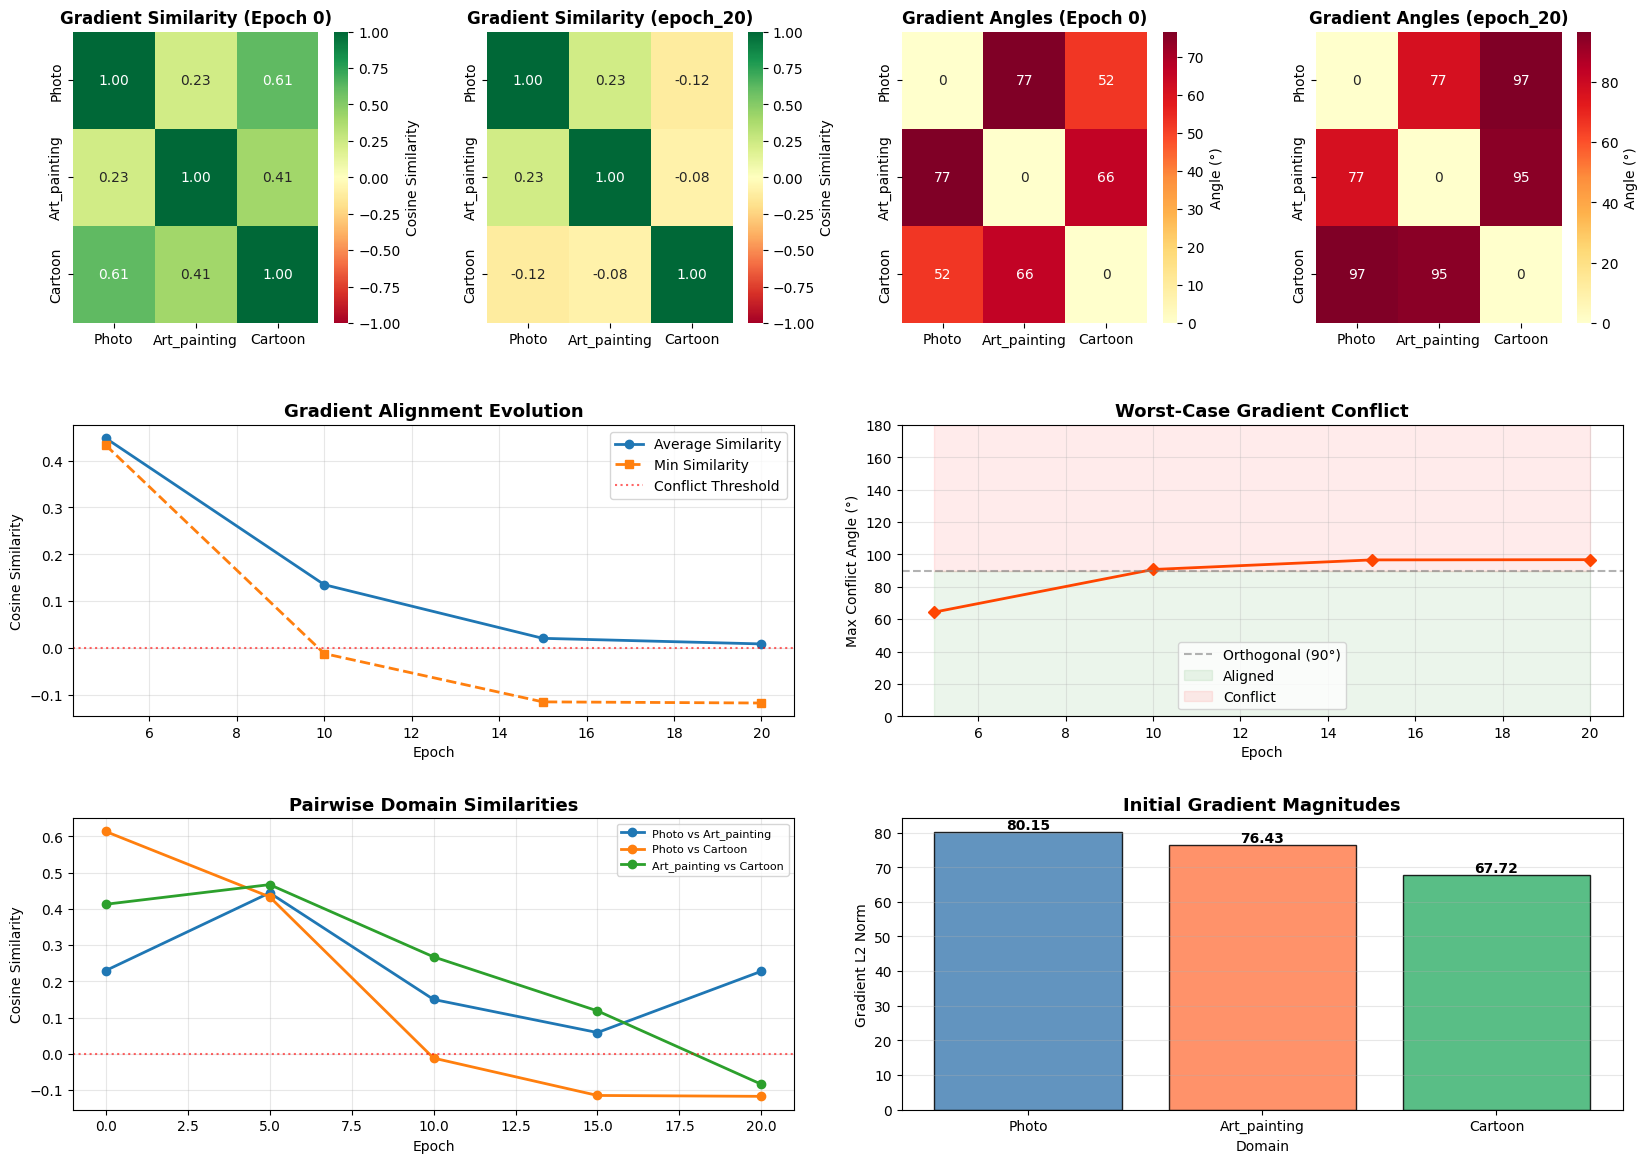


✓ Subtask 3.3 visualizations saved to /content/drive/MyDrive/ATML_Task3_Results


In [20]:
# ===== Subtask 3.3 — Visualizations (Cell 2) =====
import matplotlib.pyplot as plt, seaborn as sns

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# pick last epoch snapshot
last_epoch_key = sorted(gradient_snapshots.keys(), key=lambda k: int(k.split('_')[1]))[-1]
domain_names = list(source_loaders_grad.keys())

# 1) Similarity @ init
ax1 = fig.add_subplot(gs[0,0])
sns.heatmap(gradient_snapshots['epoch_0']['similarity'], annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, xticklabels=domain_names, yticklabels=domain_names, ax=ax1,
            cbar_kws={'label':'Cosine Similarity'})
ax1.set_title('Gradient Similarity (Epoch 0)', fontsize=12, fontweight='bold')

# 2) Similarity @ last
ax2 = fig.add_subplot(gs[0,1])
sns.heatmap(gradient_snapshots[last_epoch_key]['similarity'], annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, xticklabels=domain_names, yticklabels=domain_names, ax=ax2,
            cbar_kws={'label':'Cosine Similarity'})
ax2.set_title(f'Gradient Similarity ({last_epoch_key})', fontsize=12, fontweight='bold')

# 3) Angles @ init
ax3 = fig.add_subplot(gs[0,2])
sns.heatmap(gradient_snapshots['epoch_0']['angles'], annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=domain_names, yticklabels=domain_names, ax=ax3,
            cbar_kws={'label':'Angle (°)'})
ax3.set_title('Gradient Angles (Epoch 0)', fontsize=12, fontweight='bold')

# 4) Angles @ last
ax4 = fig.add_subplot(gs[0,3])
sns.heatmap(gradient_snapshots[last_epoch_key]['angles'], annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=domain_names, yticklabels=domain_names, ax=ax4,
            cbar_kws={'label':'Angle (°)'})
ax4.set_title(f'Gradient Angles ({last_epoch_key})', fontsize=12, fontweight='bold')

# 5) Avg / Min similarity trajectories
ax5 = fig.add_subplot(gs[1,0:2])
ax5.plot(conflict_history['epoch'], conflict_history['avg_similarity'], marker='o', linewidth=2, label='Average Similarity')
ax5.plot(conflict_history['epoch'], conflict_history['min_similarity'], marker='s', linewidth=2, linestyle='--', label='Min Similarity')
ax5.axhline(y=0, color='red', linestyle=':', alpha=0.6, label='Conflict Threshold')
ax5.set_xlabel('Epoch'); ax5.set_ylabel('Cosine Similarity'); ax5.set_title('Gradient Alignment Evolution', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10); ax5.grid(alpha=0.3)

# 6) Worst-case angle
ax6 = fig.add_subplot(gs[1,2:])
ax6.plot(conflict_history['epoch'], conflict_history['max_conflict_angle'], marker='D', linewidth=2, color='orangered')
ax6.axhline(y=90, color='gray', linestyle='--', alpha=0.6, label='Orthogonal (90°)')
ax6.fill_between(conflict_history['epoch'], 0, 90, alpha=0.08, color='green', label='Aligned')
ax6.fill_between(conflict_history['epoch'], 90, 180, alpha=0.08, color='red', label='Conflict')
ax6.set_xlabel('Epoch'); ax6.set_ylabel('Max Conflict Angle (°)'); ax6.set_title('Worst-Case Gradient Conflict', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10); ax6.grid(alpha=0.3); ax6.set_ylim([0,180])

# 7) Pairwise similarity trajectories
ax7 = fig.add_subplot(gs[2,0:2])
epochs_plotted = sorted([int(k.split('_')[1]) for k in gradient_snapshots.keys()])
for i, di in enumerate(domain_names):
    for j, dj in enumerate(domain_names):
        if i<j:
            vals = [gradient_snapshots[f'epoch_{e}']['similarity'][i,j] for e in epochs_plotted]
            ax7.plot(epochs_plotted, vals, marker='o', linewidth=2, label=f'{di} vs {dj}')
ax7.axhline(y=0, color='red', linestyle=':', alpha=0.6)
ax7.set_xlabel('Epoch'); ax7.set_ylabel('Cosine Similarity'); ax7.set_title('Pairwise Domain Similarities', fontsize=13, fontweight='bold')
ax7.legend(fontsize=8, loc='best'); ax7.grid(alpha=0.3)

# 8) Initial gradient magnitudes
ax8 = fig.add_subplot(gs[2,2:])
mag0 = {d: gradient_snapshots['epoch_0']['similarity'].shape for d in domain_names}  # placeholder for layout
# compute true magnitudes from grads_init we computed earlier
grad_magnitudes = {d: grads_init[d].norm().item() for d in domain_names}
bars = ax8.bar(list(grad_magnitudes.keys()), list(grad_magnitudes.values()),
               color=['steelblue','coral','mediumseagreen','gold','orchid'][:len(grad_magnitudes)],
               alpha=0.85, edgecolor='black')
ax8.set_xlabel('Domain'); ax8.set_ylabel('Gradient L2 Norm'); ax8.set_title('Initial Gradient Magnitudes', fontsize=13, fontweight='bold')
ax8.grid(axis='y', alpha=0.3)
for b in bars:
    ax8.text(b.get_x()+b.get_width()/2, b.get_height(), f"{b.get_height():.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig(f"{output_dir}/subtask3.3_gradient_conflict_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Subtask 3.3 visualizations saved to {output_dir}")


# Subtask 3.4: Open-Set and Generalization Analysis


In [21]:
# ===== Subtask 3.4 — Open-Set & Generalization Analysis (Cell 1) =====
import torch, numpy as np, pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve

print("\n" + "="*50)
print("SUBTASK 3.4: OPEN-SET AND GENERALIZATION ANALYSIS")
print("="*50)

# ---------------------------------------------------------------------
# 0) Minimal CoOp wrapper (if not already defined)
# ---------------------------------------------------------------------
if 'CoOpCLIPLite' not in globals():
    class PromptLearnerLite(nn.Module):
        def __init__(self, clip_model, class_names, n_ctx=16, class_specific=True, ctx_init=None, device=None):
            super().__init__()
            self.class_names = class_names
            self.n_cls = len(class_names)
            self.n_ctx = n_ctx
            self.class_specific = class_specific
            self.device = device or next(clip_model.parameters()).device

            self.embed = clip_model.token_embedding
            self.dtype = clip_model.dtype

            tokenized = clip.tokenize(class_names).to(self.device)
            with torch.no_grad():
                emb = self.embed(tokenized).type(self.dtype)   # (C,77,dim)

            self.register_buffer("tokenized", tokenized)
            self.register_buffer("base_embedding", emb)

            eos_token = 49407
            self.name_lens = []
            for i in range(self.n_cls):
                row = tokenized[i]
                eos_pos = (row == eos_token).nonzero(as_tuple=True)[0]
                eos_pos = int(eos_pos[0].item()) if len(eos_pos) else 77
                self.name_lens.append(max(1, eos_pos - 1))

            dim = emb.shape[-1]
            if ctx_init is not None:
                init_tok = clip.tokenize(ctx_init).to(self.device)
                with torch.no_grad():
                    init_emb = self.embed(init_tok).type(torch.float32)
                ctx = init_emb[:, 1:1+n_ctx, :].clone()
                if ctx.size(1) < n_ctx:
                    pad = torch.randn(1, n_ctx-ctx.size(1), dim, device=self.device, dtype=torch.float32) * 0.02
                    ctx = torch.cat([ctx, pad], dim=1)
            else:
                ctx = torch.randn(1, n_ctx, dim, device=self.device, dtype=torch.float32) * 0.02

            if class_specific:
                self.ctx = nn.Parameter(ctx.repeat(self.n_cls, 1, 1))  # (C,n_ctx,dim)
            else:
                self.ctx = nn.Parameter(ctx)                            # (1,n_ctx,dim)

        def forward(self):
            C, n_ctx = self.n_cls, self.n_ctx
            emb = self.base_embedding
            prefix = emb[:, :1, :]  # SOS
            if self.class_specific:
                ctx = self.ctx
            else:
                ctx = self.ctx.expand(C, n_ctx, -1)
            ctx = ctx.to(emb.dtype)

            prompts = []
            for i in range(C):
                name_len = self.name_lens[i]
                name_tokens = emb[i:i+1, 1:1+name_len, :]
                suffix = emb[i:i+1, 1+name_len:, :]
                p = torch.cat([prefix[i:i+1], ctx[i:i+1], name_tokens, suffix], dim=1)
                p = p[:, :77, :]
                if p.size(1) < 77:
                    pad = torch.zeros(1, 77-p.size(1), p.size(2), device=p.device, dtype=p.dtype)
                    p = torch.cat([p, pad], dim=1)
                prompts.append(p)
            return torch.cat(prompts, dim=0)  # (C,77,dim)

    class CoOpCLIPLite(nn.Module):
        def __init__(self, clip_model, class_names, n_ctx=16, class_specific=True, ctx_init=None, device=None):
            super().__init__()
            self.clip = clip_model
            for p in self.clip.visual.parameters(): p.requires_grad = False
            for p in self.clip.transformer.parameters(): p.requires_grad = False
            self.clip.token_embedding.weight.requires_grad = False
            self.clip.ln_final.weight.requires_grad = False
            self.clip.ln_final.bias.requires_grad = False
            self.prompt_learner = PromptLearnerLite(clip_model, class_names, n_ctx=n_ctx,
                                                    class_specific=class_specific, ctx_init=ctx_init, device=device)

        @torch.no_grad()
        def encode_image(self, images):
            x = self.clip.encode_image(images)
            return x / x.norm(dim=-1, keepdim=True)

        def _encode_text_from_emb(self, prompts):
            x = prompts + self.clip.positional_embedding.type(prompts.dtype)
            x = x.permute(1,0,2)
            x = self.clip.transformer(x)
            x = x.permute(1,0,2)
            x = self.clip.ln_final(x)
            eos = (self.prompt_learner.tokenized == 49407).float().argmax(dim=1)
            feats = x[torch.arange(x.size(0)), eos] @ self.clip.text_projection
            return feats / feats.norm(dim=-1, keepdim=True)

        def text_features(self):
            return self._encode_text_from_emb(self.prompt_learner())

        def forward(self, images):
            img = self.encode_image(images)
            txt = self.text_features()
            return 100.0 * img @ txt.t()

# ---------------------------------------------------------------------
# 1) Choose closed-set (seen) vs held-out (unseen) classes
# ---------------------------------------------------------------------
TRAIN_CLASSES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse']  # seen
HOLDOUT_CLASSES = ['house', 'person']                               # unseen
PACS_CLASSES = PACS_CLASSES  # from your globals

print(f"Training classes: {TRAIN_CLASSES}")
print(f"Holdout classes:  {HOLDOUT_CLASSES}")

# global mapping
CLASS2IDX = {c:i for i,c in enumerate(PACS_CLASSES)}
train_idx_set = {CLASS2IDX[c] for c in TRAIN_CLASSES}

# Data splits
source_loaders = {k:v for k,v in all_loaders.items() if k != "Sketch"}
target_loader = all_loaders["Sketch"]

# ---------------------------------------------------------------------
# 2) Train a closed-set CoOp prompt head (only on TRAIN_CLASSES)
# ---------------------------------------------------------------------
clip_model_cs, _ = clip.load("ViT-B/32", device=device)
closedset_model = CoOpCLIPLite(clip_model_cs, TRAIN_CLASSES, n_ctx=16, class_specific=True, ctx_init=None, device=device).to(device)

opt = torch.optim.SGD([p for p in closedset_model.prompt_learner.parameters() if p.requires_grad],
                      lr=0.005, momentum=0.9, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

print("\n--- Training closed-set prompt head on sources (seen classes only) ---")
for ep in range(1, 16):  # 15 epochs is enough for analysis
    closedset_model.train()
    for dom, loader in source_loaders.items():
        for x, y in loader:
            # filter to seen classes
            m = np.isin(y.numpy(), list(train_idx_set))
            if not m.any():
                continue
            x = x[m].to(device)
            # remap labels to 0..len(TRAIN_CLASSES)-1
            y_seen = [TRAIN_CLASSES.index(PACS_CLASSES[int(lbl)]) for lbl in y[m].numpy()]
            y_seen = torch.tensor(y_seen, device=device, dtype=torch.long)

            opt.zero_grad(set_to_none=True)
            logits = closedset_model(x)               # (B, |TRAIN|)
            loss = crit(logits, y_seen)
            loss.backward()
            opt.step()
    if ep % 5 == 0:
        print(f"Epoch {ep}/15 done")

print("Closed-set training complete.")

# ---------------------------------------------------------------------
# 3) Build Zero-Shot head over ALL PACS classes (for comparison)
# ---------------------------------------------------------------------
def build_zeroshot_head(clip_model, class_names, templates, device):
    with torch.no_grad():
        feats=[]
        for tpl in templates:
            texts=[tpl.format(c) for c in class_names]
            toks = clip.tokenize(texts).to(device)
            tf = clip_model.encode_text(toks)
            tf = tf / tf.norm(dim=-1, keepdim=True)
            feats.append(tf)
        tf = torch.stack(feats).mean(0)
        tf = tf / tf.norm(dim=-1, keepdim=True)
    return tf  # (C,D)

zs_clip, _ = clip.load("ViT-B/32", device=device)
zs_templates = ["a sketch of a {}.","a drawing of a {}.","a pencil sketch of a {}."]
zs_text = build_zeroshot_head(zs_clip, PACS_CLASSES, zs_templates, device)

@torch.no_grad()
def logits_zeroshot(clip_model, images, text_feats):
    img = clip_model.encode_image(images)
    img = img / img.norm(dim=-1, keepdim=True)
    return 100.0 * img @ text_feats.t()

# ---------------------------------------------------------------------
# 4) Open-set evaluation utilities (MSP, ECE, AUROC, FPR@95)
# ---------------------------------------------------------------------
def msp_scores_from_logits(logits):
    probs = F.softmax(logits, dim=1)
    msp = probs.max(dim=1).values
    return probs, msp

def compute_ece(probs, correct, n_bins=10):
    probs = np.asarray(probs); correct = np.asarray(correct, dtype=bool)
    bins = np.linspace(0,1,n_bins+1)
    ece=0.0
    for i in range(n_bins):
        m = (probs>=bins[i]) & (probs<bins[i+1])
        if m.sum()>0:
            ece += m.mean() * abs(correct[m].mean() - probs[m].mean())
    return float(ece)

def fpr_at_tpr95(labels_is_unseen, scores_ood):  # scores_ood: higher means *more* OOD
    # Treat negatives=seen(0), positives=unseen(1)
    fpr, tpr, thr = roc_curve(labels_is_unseen, scores_ood)
    # find closest tpr >= 0.95
    idx = np.argmax(tpr >= 0.95)
    return float(fpr[idx]) if (tpr >= 0.95).any() else np.nan

def evaluate_openset_zero_shot(target_loader):
    zs_clip.eval()
    seen_correct = []   # correctness only for seen
    seen_confs   = []
    unseen_confs = []
    all_ood_labels = [] # 1=unseen, 0=seen
    all_ood_scores = [] # 1-MSP

    with torch.no_grad():
        for x,y in target_loader:
            x = x.to(device)
            logits = logits_zeroshot(zs_clip, x, zs_text)   # (B, |PACS|)
            probs, msp = msp_scores_from_logits(logits)
            preds = probs.argmax(1).cpu().numpy()
            msp_cpu = msp.cpu().numpy()
            y_np = y.numpy()
            for i, true in enumerate(y_np):
                is_seen = (true in train_idx_set)
                is_unseen = 0 if is_seen else 1
                all_ood_labels.append(is_unseen)
                all_ood_scores.append(1.0 - msp_cpu[i])     # higher => more OOD

                if is_seen:
                    seen_correct.append(int(preds[i] == true))
                    seen_confs.append(msp_cpu[i])
                else:
                    unseen_confs.append(msp_cpu[i])

    seen_acc = np.mean(seen_correct) if seen_correct else 0.0
    ece_seen = compute_ece(np.array(seen_confs), np.array(seen_correct)) if seen_confs else 0.0
    auroc = roc_auc_score(all_ood_labels, all_ood_scores) if len(set(all_ood_labels))>1 else np.nan
    fpr95 = fpr_at_tpr95(np.array(all_ood_labels), np.array(all_ood_scores))
    return {
        'seen_accuracy': seen_acc,
        'avg_unseen_confidence': float(np.mean(unseen_confs)) if unseen_confs else 0.0,
        'ece_seen': ece_seen,
        'seen_probs': seen_confs,
        'unseen_probs': unseen_confs,
        'seen_count': int(np.sum(np.array(all_ood_labels)==0)),
        'unseen_count': int(np.sum(np.array(all_ood_labels)==1)),
        'auroc_ood': float(auroc) if auroc==auroc else np.nan,
        'fpr95_ood': fpr95
    }

def evaluate_openset_prompt(target_loader, closedset_model):
    closedset_model.eval()
    seen_correct = []
    seen_confs   = []
    unseen_confs = []
    all_ood_labels = []
    all_ood_scores = []

    with torch.no_grad():
        for x,y in target_loader:
            x = x.to(device)
            logits = closedset_model(x)                      # (B, |TRAIN|)
            probs, msp = msp_scores_from_logits(logits)
            msp_cpu = msp.cpu().numpy()
            y_np = y.numpy()

            for i, true in enumerate(y_np):
                is_seen = (true in train_idx_set)
                is_unseen = 0 if is_seen else 1
                all_ood_labels.append(is_unseen)
                all_ood_scores.append(1.0 - msp_cpu[i])     # higher => more OOD

                if is_seen:
                    # remap true to the TRAIN index
                    true_name = PACS_CLASSES[int(true)]
                    true_local = TRAIN_CLASSES.index(true_name)
                    pred_local = probs[i].argmax().item()
                    seen_correct.append(int(pred_local == true_local))
                    seen_confs.append(msp_cpu[i])
                else:
                    unseen_confs.append(msp_cpu[i])

    seen_acc = np.mean(seen_correct) if seen_correct else 0.0
    ece_seen = compute_ece(np.array(seen_confs), np.array(seen_correct)) if seen_confs else 0.0
    auroc = roc_auc_score(all_ood_labels, all_ood_scores) if len(set(all_ood_labels))>1 else np.nan
    fpr95 = fpr_at_tpr95(np.array(all_ood_labels), np.array(all_ood_scores))
    return {
        'seen_accuracy': seen_acc,
        'avg_unseen_confidence': float(np.mean(unseen_confs)) if unseen_confs else 0.0,
        'ece_seen': ece_seen,
        'seen_probs': seen_confs,
        'unseen_probs': unseen_confs,
        'seen_count': int(np.sum(np.array(all_ood_labels)==0)),
        'unseen_count': int(np.sum(np.array(all_ood_labels)==1)),
        'auroc_ood': float(auroc) if auroc==auroc else np.nan,
        'fpr95_ood': fpr95
    }

# ---------------------------------------------------------------------
# 5) Evaluate on Sketch (target)
# ---------------------------------------------------------------------
print("\n--- Evaluating Open-Set on Sketch ---")
results_zs_openset = evaluate_openset_zero_shot(target_loader)
results_cs_openset = evaluate_openset_prompt(target_loader, closedset_model)

print("\nOpen-Set Results (Sketch):")
print(f"{'Method':<26} {'Seen Acc':<10} {'Unseen MSP':<12} {'ECE':<10} {'AUROC':<10} {'FPR@95':<10}")
print("="*80)
print(f"{'Zero-Shot CLIP':<26} {results_zs_openset['seen_accuracy']:<10.3f} "
      f"{results_zs_openset['avg_unseen_confidence']:<12.3f} "
      f"{results_zs_openset['ece_seen']:<10.3f} "
      f"{results_zs_openset['auroc_ood']:<10.3f} "
      f"{results_zs_openset['fpr95_ood']:<10.3f}")
print(f"{'Tuned Prompt (Closed)':<26} {results_cs_openset['seen_accuracy']:<10.3f} "
      f"{results_cs_openset['avg_unseen_confidence']:<12.3f} "
      f"{results_cs_openset['ece_seen']:<10.3f} "
      f"{results_cs_openset['auroc_ood']:<10.3f} "
      f"{results_cs_openset['fpr95_ood']:<10.3f}")

# Save numeric summary
openset_comparison = pd.DataFrame({
    'Method': ['Zero-Shot CLIP', 'Tuned Prompt (Closed-Set)'],
    'Seen Accuracy': [results_zs_openset['seen_accuracy'], results_cs_openset['seen_accuracy']],
    'Avg Unseen MSP (↓)': [results_zs_openset['avg_unseen_confidence'], results_cs_openset['avg_unseen_confidence']],
    'ECE (Seen, ↓)': [results_zs_openset['ece_seen'], results_cs_openset['ece_seen']],
    'AUROC (OOD, ↑)': [results_zs_openset['auroc_ood'], results_cs_openset['auroc_ood']],
    'FPR@95 (OOD, ↓)': [results_zs_openset['fpr95_ood'], results_cs_openset['fpr95_ood']],
    'Seen Count': [results_zs_openset['seen_count'], results_cs_openset['seen_count']],
    'Unseen Count': [results_zs_openset['unseen_count'], results_cs_openset['unseen_count']],
})
openset_comparison.to_csv(f"{output_dir}/subtask3.4_openset_comparison.csv", index=False)

# Stash objects for Cell 2
_oz = results_zs_openset
_oc = results_cs_openset
_closedset_model = closedset_model
_zs_text_full = zs_text
print("\nSaved: subtask3.4_openset_comparison.csv")



SUBTASK 3.4: OPEN-SET AND GENERALIZATION ANALYSIS
Training classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse']
Holdout classes:  ['house', 'person']

--- Training closed-set prompt head on sources (seen classes only) ---
Epoch 5/15 done
Epoch 10/15 done
Epoch 15/15 done
Closed-set training complete.

--- Evaluating Open-Set on Sketch ---

Open-Set Results (Sketch):
Method                     Seen Acc   Unseen MSP   ECE        AUROC      FPR@95    
Zero-Shot CLIP             0.847      0.851        0.064      0.591      0.958     
Tuned Prompt (Closed)      0.859      0.794        0.061      0.815      0.353     

Saved: subtask3.4_openset_comparison.csv


/tmp/ipython-input-579515275.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True)


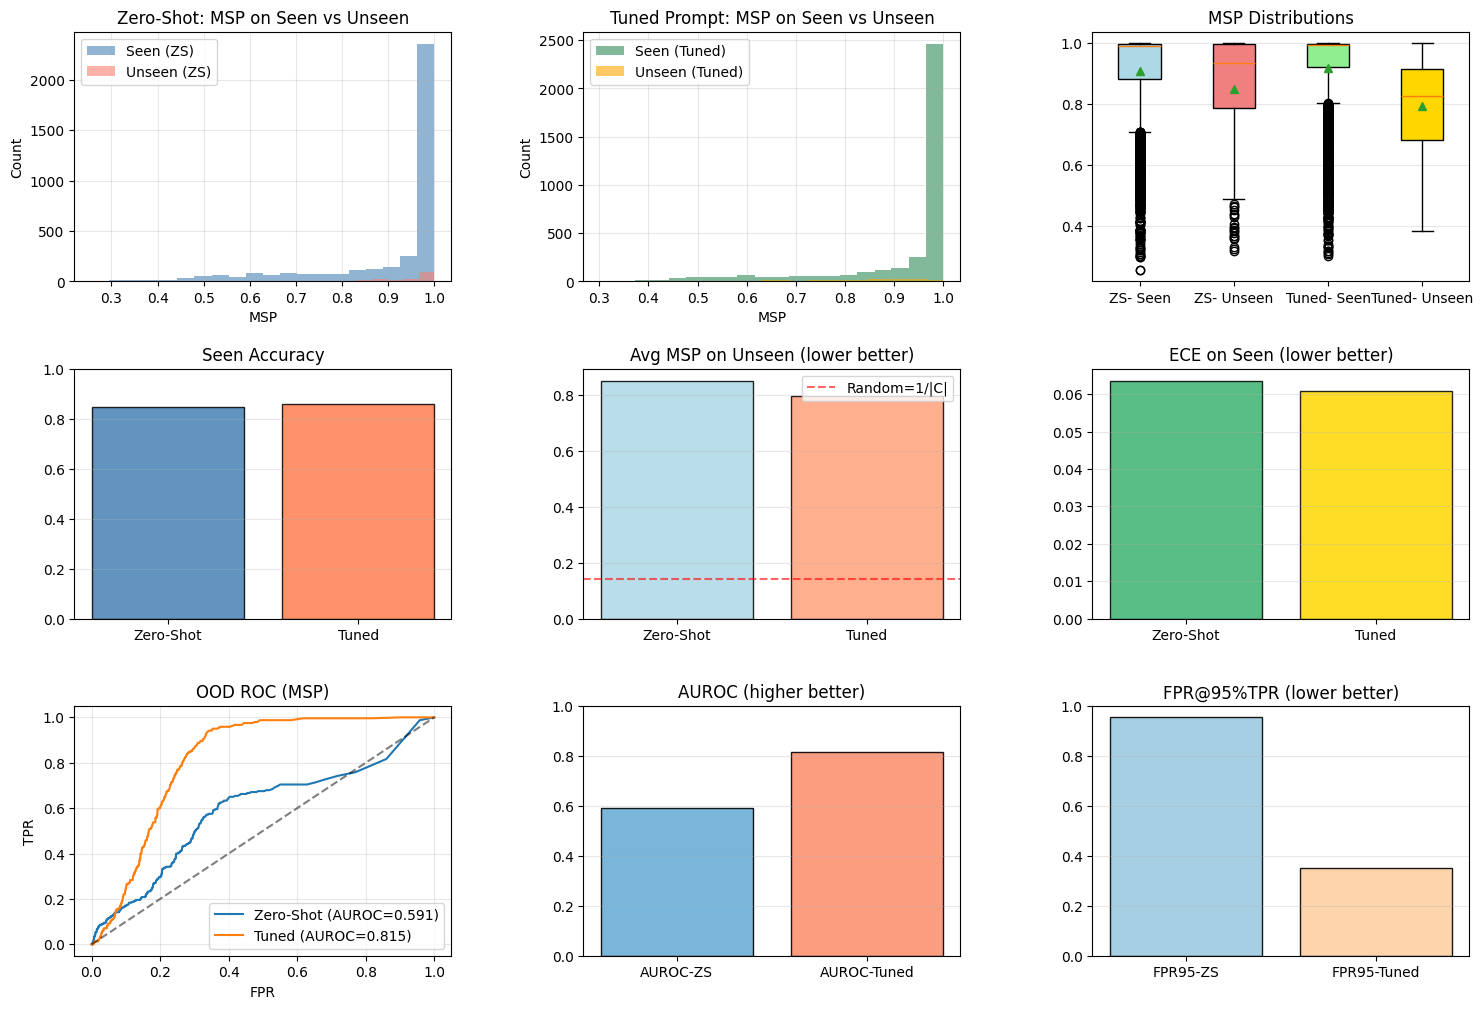


Prompt cosine (closed-set vs zero-shot head on TRAIN classes): 0.500

✓ Subtask 3.4 visualizations saved to /content/drive/MyDrive/ATML_Task3_Results


In [22]:
# ===== Subtask 3.4 — Visualizations & Prompt Similarity (Cell 2) =====
import matplotlib.pyplot as plt, seaborn as sns

results_zs_openset = _oz
results_cs_openset = _oc
closedset_model = _closedset_model
zs_text_full = _zs_text_full

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1–2) Confidence histograms (MSP) — Zero-Shot vs Tuned
ax1 = fig.add_subplot(gs[0,0])
ax1.hist(results_zs_openset['seen_probs'],   bins=20, alpha=0.6, label='Seen (ZS)',   color='steelblue')
ax1.hist(results_zs_openset['unseen_probs'], bins=20, alpha=0.6, label='Unseen (ZS)', color='salmon')
ax1.set_title('Zero-Shot: MSP on Seen vs Unseen'); ax1.set_xlabel('MSP'); ax1.set_ylabel('Count'); ax1.legend(); ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0,1])
ax2.hist(results_cs_openset['seen_probs'],   bins=20, alpha=0.6, label='Seen (Tuned)',   color='seagreen')
ax2.hist(results_cs_openset['unseen_probs'], bins=20, alpha=0.6, label='Unseen (Tuned)', color='orange')
ax2.set_title('Tuned Prompt: MSP on Seen vs Unseen'); ax2.set_xlabel('MSP'); ax2.set_ylabel('Count'); ax2.legend(); ax2.grid(alpha=0.3)

# 3) Boxplot comparison
ax3 = fig.add_subplot(gs[0,2])
data_to_plot = [results_zs_openset['seen_probs'], results_zs_openset['unseen_probs'],
                results_cs_openset['seen_probs'], results_cs_openset['unseen_probs']]
labels = ['ZS- Seen','ZS- Unseen','Tuned- Seen','Tuned- Unseen']
bp = ax3.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True)
for patch, c in zip(bp['boxes'], ['lightblue','lightcoral','lightgreen','gold']):
    patch.set_facecolor(c)
ax3.set_title('MSP Distributions'); ax3.grid(axis='y', alpha=0.3)

# 4) Seen-class accuracy + 5) Avg unseen MSP + 6) ECE
ax4 = fig.add_subplot(gs[1,0]); ax5 = fig.add_subplot(gs[1,1]); ax6 = fig.add_subplot(gs[1,2])
xs = np.arange(2); labels_m = ['Zero-Shot','Tuned']
ax4.bar(xs, [results_zs_openset['seen_accuracy'], results_cs_openset['seen_accuracy']],
        color=['steelblue','coral'], edgecolor='black', alpha=0.85)
ax4.set_title('Seen Accuracy'); ax4.set_xticks(xs); ax4.set_xticklabels(labels_m); ax4.set_ylim(0,1); ax4.grid(axis='y', alpha=0.3)

ax5.bar(xs, [results_zs_openset['avg_unseen_confidence'], results_cs_openset['avg_unseen_confidence']],
        color=['lightblue','lightsalmon'], edgecolor='black', alpha=0.85)
ax5.axhline(y=1/len(PACS_CLASSES), color='red', linestyle='--', alpha=0.6, label='Random=1/|C|')
ax5.set_title('Avg MSP on Unseen (lower better)'); ax5.set_xticks(xs); ax5.set_xticklabels(labels_m); ax5.legend(); ax5.grid(axis='y', alpha=0.3)

ax6.bar(xs, [results_zs_openset['ece_seen'], results_cs_openset['ece_seen']],
        color=['mediumseagreen','gold'], edgecolor='black', alpha=0.85)
ax6.set_title('ECE on Seen (lower better)'); ax6.set_xticks(xs); ax6.set_xticklabels(labels_m); ax6.grid(axis='y', alpha=0.3)

# 7) OOD ROC curves (MSP-based)
ax7 = fig.add_subplot(gs[2,0])
# Rebuild OOD vectors for ROC plot
def rebuild_ood_vectors(res):
    seen = len(res['seen_probs']); unseen = len(res['unseen_probs'])
    labels = np.array([0]*seen + [1]*unseen)       # 0=seen (ID), 1=unseen (OOD)
    scores = np.array([1.0 - p for p in res['seen_probs']] +
                      [1.0 - p for p in res['unseen_probs']])  # higher => OOD
    return labels, scores

lz, sz = rebuild_ood_vectors(results_zs_openset)
lc, sc = rebuild_ood_vectors(results_cs_openset)
from sklearn.metrics import roc_curve, auc
fpr_z, tpr_z, _ = roc_curve(lz, sz); auc_z = auc(fpr_z, tpr_z)
fpr_c, tpr_c, _ = roc_curve(lc, sc); auc_c = auc(fpr_c, tpr_c)
ax7.plot(fpr_z, tpr_z, label=f"Zero-Shot (AUROC={auc_z:.3f})")
ax7.plot(fpr_c, tpr_c, label=f"Tuned (AUROC={auc_c:.3f})")
ax7.plot([0,1],[0,1],'k--',alpha=0.5)
ax7.set_xlabel('FPR'); ax7.set_ylabel('TPR'); ax7.set_title('OOD ROC (MSP)'); ax7.legend(); ax7.grid(alpha=0.3)

# 8) OOD bars: AUROC & FPR@95
ax8 = fig.add_subplot(gs[2,1])
ax8.bar(['AUROC-ZS','AUROC-Tuned'], [results_zs_openset['auroc_ood'], results_cs_openset['auroc_ood']],
        color=['#6baed6','#fc9272'], alpha=0.9, edgecolor='black')
ax8.set_ylim(0,1); ax8.set_title('AUROC (higher better)'); ax8.grid(axis='y', alpha=0.3)

ax9 = fig.add_subplot(gs[2,2])
ax9.bar(['FPR95-ZS','FPR95-Tuned'], [results_zs_openset['fpr95_ood'], results_cs_openset['fpr95_ood']],
        color=['#9ecae1','#fdd0a2'], alpha=0.9, edgecolor='black')
ax9.set_ylim(0,1); ax9.set_title('FPR@95%TPR (lower better)'); ax9.grid(axis='y', alpha=0.3)

plt.savefig(f"{output_dir}/subtask3.4_openset_comprehensive.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------- Prompt-similarity diagnostic ----------------------
# Cosine similarity between closed-set learned text head and Zero-Shot text head (on TRAIN classes)
with torch.no_grad():
    cs_text = closedset_model.text_features()  # (|TRAIN|, D)
    # slice zs_text to the same TRAIN class order
    zs_idx_train = torch.tensor([CLASS2IDX[c] for c in TRAIN_CLASSES], device=device)
    zs_train_text = zs_text_full[zs_idx_train]  # (|TRAIN|, D)
    # normalize already normalized, but be safe
    cs_text = cs_text / cs_text.norm(dim=-1, keepdim=True)
    zs_train_text = zs_train_text / zs_train_text.norm(dim=-1, keepdim=True)
    cos = (cs_text * zs_train_text).sum(dim=-1).mean().item()

print(f"\nPrompt cosine (closed-set vs zero-shot head on TRAIN classes): {cos:.3f}")
print(f"\n✓ Subtask 3.4 visualizations saved to {output_dir}")
